In [1]:
%matplotlib inline
from pylab import *
import cv2
import rasterio

rcParams['figure.figsize'] = 10, 10

from dataset import load_image

import torch
from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from utils import variable
from generate_masks import get_model
from unet_models import unet11_MS


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


# DEMO ALTERED. THESE CELLS GENERATE SOME DATA

In [2]:
# import the helper functions
from test_unet_helpers import *

import glob
import os,sys
from matplotlib import pyplot as plt
import numpy as np
from scipy import misc
import fiona
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
# specify scene id for DG data
dg_scene_id = '1030010057062200'

# specify image for 2.0 meter analysis
gt_image_2 = '../rasters/union_impervious_raster_2_0_0_wgs84.tif' # desktop

# specify images for 0.5 meter analysis
gt_image_05 = '../rasters/union_impervious_raster_0_5.tif' # desktop

# specify the shapefile
shpfile = '../union/union.shp' # desktop
rows = []
with fiona.open(shpfile) as shp:
    crs = shp.crs
    shp_bounds = shp.bounds

In [4]:
from gbdxtools import Interface, CatalogImage

# connect to gbdx
gbdx = Interface()

# get the dask array for the 8 band MS image
img_2m = CatalogImage(dg_scene_id, band_type='MS', bbox=shp_bounds, acomp=True)
rows, cols = img_2m.shape[1:]

# get the dask array for the Pansharpened, 4 band image
image_05m = CatalogImage(dg_scene_id, bbox=shp_bounds, acomp=True, pansharpen=True)
rowsP, colsP = image_05m.shape[1:]
pan_factorR = np.floor(rowsP/rows)
pan_factorC = np.floor(colsP/cols)

In [5]:
torch.cuda.device_count()

4

In [6]:
# generate the sample points
# we have some funny stuff from ArcGIS converting the polygons to a raster... so... 
# generate the points within the bounds of the shapefile / DG image array

import random

random.seed(10)

num = 10000
side = 64
coords = []
coords_pan = []
im_patches = []
im_patches_pan = []

with rasterio.open(gt_image_2, 'r') as src:
    
    for i in range(num):
        ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
        #print('generating sample {} of {}'.format(i+1, num))

        try:
            r_start = ran_row - side/2
            r_end = ran_row + side/2
            c_start = ran_col - side/2
            c_end = ran_col + side/2
            #im_data = img_2m[:, r_start:r_end, c_start:c_end]

            pr_start = ran_row*pan_factorR - side/2
            pr_end = ran_row*pan_factorR + side/2
            pc_start = ran_col*pan_factorC - side/2
            pc_end = ran_col*pan_factorC + side/2
            #im_data_pan = image_05m[:, pr_start:pr_end, pc_start:pc_end]

            # append regardless and check later.

            #############################################################################################################
            ### SHOULD CHECK THE INFORMATION THRESHOLDS BELOW, BUT HERE, TO RESELECT ROWS AND COLUMNS UNTIL IT IS MET ###
            #############################################################################################################

            s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
            pt_flag = checkWindow(src, s_pt)
            ct = 0
            while pt_flag:
                ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
                s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
                pt_flag = checkWindow(src, s_pt)
                
                ct+=1
                # exit loop after 1000 tries
                if ct > 1000:
                    break
            if ct > 1000:
                print('1000 tries, moving on')
                continue
                
                
            coords.append((ran_row, ran_col))
            coords_pan.append(( int(ran_row*pan_factorR), int(ran_col*pan_factorC)))

        except Exception as e:
            print(e)

    coords_arr = np.array(coords)  

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
lonlat_MS = [calcXYfromRC(img_2m.affine, pair) for pair in coords]
lonlat_PAN = [calcXYfromRC(image_05m.affine, pair) for pair in coords_pan]

In [8]:
import pyproj
       
def assignRC2(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    outProj = Proj(init=outproj)
    inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x2,y2)
    r,c = [int(c) for c in temp]
    
    return ((x3,y3), samp_pt, r,c)

def assignRC3(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    #outProj = Proj(init=outproj)
    #inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    #x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    #x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x1,y1)
    r,c = [int(c) for c in temp]
    
    return ((x1,y1), samp_pt, r,c)

# use the lonlats_* lists to sample the ground truth image. return the histogram if the window is on the border,
# which should be evident if the window extends across
with rasterio.open(gt_image_2, 'r') as src:
    #print(src.crs)

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_MS = [assignRC3(src, samp_pt) for samp_pt in lonlat_MS]

# do the same for the 0.5 meter ground truth raster
with rasterio.open(gt_image_05, 'r') as src:

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_PAN = [assignRC(src, samp_pt) for samp_pt in lonlat_MS]




In [9]:
# image transform for DG imagery
img_transform = Compose([
    Normalize(mean=[1545.9403, 1460.1287, 1452.7002, 1466.6466, 1511.6293, 1902.1776, 2497.181, 2167.458], 
              std=[512.423, 672.7396, 743.9062, 840.52625, 918.4014, 828.56976, 1196.6774, 1061.4962])
])

In [10]:
# for i in range(8):
#     print(img_2m[i,:,:].mean().compute(), img_2m[i,:,:].std().compute())

## Train the initial model with a subset of the sample points.. need to edit the source code to use the input data classes instead of data loaders.
### to use the dataloader, may need to create some attributes on the class such as self.__len__

In [11]:
val_test_percentage = 0.2
train_ind = int(num - num * val_test_percentage)
val_ind = int((num - train_ind)*0.5)
val_ind = train_ind + val_ind
train_ind, val_ind


(8000, 9000)

In [12]:
bsize = 100

## establish the data loaders
from torch.utils.data import DataLoader

# ground truth
gt_transform = Compose([
    ToTensor()
    ])
gt_dataset_train = gtDatasetSampler2(gt_image_2, coords[:train_ind], transform=gt_transform) 
# gt_dataset_train = gtDatasetSampler2(gt_image_2, coords[:1000], transform=gt_transform) # debug 
gt_dataset_val = gtDatasetSampler2(gt_image_2, coords[train_ind:val_ind], transform=gt_transform)
gt_dataset_test = gtDatasetSampler2(gt_image_2, coords[val_ind:], transform=gt_transform)

gt_dl_train = DataLoader(gt_dataset_train, batch_size=bsize, shuffle=False)
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False)


#DG
dg_dataset_train = DigitalGlobeSamplerTensor(img_2m, coords[:train_ind], transform=img_transform, comb='all') # will return RGB by default
# dg_dataset_train = DigitalGlobeSamplerTensor(img_2m, coords[:1000], transform=img_transform) # debug
dg_dataset_val = DigitalGlobeSamplerTensor(img_2m, coords[train_ind:val_ind], transform=img_transform, comb='all')
dg_dataset_test = DigitalGlobeSamplerTensor(img_2m, coords[val_ind:], transform=img_transform, comb='all')

dg_dl_train = DataLoader(dg_dataset_train, batch_size=bsize, shuffle=False)
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False)

In [13]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
        
args = {}
args['lr'] = 0.0001
args['n_epochs'] = 4
args['batch_size'] = bsize
args['root'] = 'runs/debug'
args['fold']=0
args['jaccard_weight'] = 1

# convert dict keys to objects and specify lr
args = objectview(args)
lr = args.lr

In [14]:
from datetime import datetime

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()
    
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))



In [15]:
import utils as pyt_utils
from torch.optim import Adam
import torch.backends.cudnn as cudnn
from pathlib import Path
from validation import validation_binary
from loss import LossBinary
import json

# need to change this to DICE loss!
#loss = LossBinary(jaccard_weight=args.jaccard_weight)
#criterion = nn.CrossEntropyLoss()


cudnn.benchmark = True

root = Path(args.root)
root.mkdir(exist_ok=True, parents=True)
root.joinpath('params.json').write_text(
    json.dumps(vars(args), indent=True, sort_keys=True))

valid = validation_binary

num_classes=1

## TRY A LOCAL IMPLEMENTATION OF UNET

In [16]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=2, depth=5, wf=6, padding=False,
                 batch_norm=False, up_mode='upconv'):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(UNetConvBlock(prev_channels, 2**(wf+i),
                                                padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(UNetUpBlock(prev_channels, 2**(wf+i), up_mode,
                                            padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path)-1:
                blocks.append(x)
                x = F.avg_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i-1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2,
                                         stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2),
                                    nn.Conv2d(in_size, out_size, kernel_size=1))

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[:, :, diff_y:(diff_y + target_size[0]), diff_x:(diff_x + target_size[1])]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

In [17]:
import time
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
# from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split

## call outside training method, in loop

# iterate over some batch sizes
times = []
# batch_sizes = [50, 100, 200,300,400,500,600,700,800,900,1000]
bsize = 8 # smaller batch sizes as per https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network
# model = unet11_MS(pretrained=False)
model = UNet(in_channels=8, n_classes=1, padding=True)

# set some parameters
lr = 0.0001
optimizer = Adam(model.parameters(), lr=lr)
criterion = LossBinary(jaccard_weight=args.jaccard_weight)
# criterion = nn.BCELoss()

# make model parallel and on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    #model = nn.DataParallel(model)
    model.to(device)

optimizer = Adam(model.parameters(), lr=lr)
criterion = LossBinary(jaccard_weight=args.jaccard_weight)
# criterion = nn.BCELoss()

print('batchsize, ', bsize)
mean_loss = 0.0
running_loss = 0.0
print('training...')

losses=[]
losses_ep = []
#tl = zip(dg_dl_train, gt_dl_train)
step=0


###### specify DataLoaders
## GT
gt_dl_train = DataLoader(gt_dataset_train, batch_size=bsize, shuffle=False, num_workers=4)
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False, num_workers=4)


## DG
dg_dl_train = DataLoader(dg_dataset_train, batch_size=bsize, shuffle=False, num_workers=4)
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False, num_workers=4)


# record time for one epoch
t0 = time.time()
for epoch in range(100):
    
    try:
        te = time.time()

        epoch_i = epoch+1
        print('on epoch {}'.format(epoch_i))
        tl = zip(dg_dl_train, gt_dl_train) # this can't be defined outside the loop. This suggests it is...cashing out??
        for i, (inputs_, targets_) in enumerate(tl):

            # get the inputs
            #inputs, targets = variable(inputs_).cuda(), variable(targets_).cuda()
            inputs, targets = variable(inputs_), variable(targets_)
            inputs.to(device)
            targets.to(device)

            outputs = model(inputs)

            # zero parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize            
            i_loss = criterion(outputs, targets)                
            i_loss.backward()
            optimizer.step()
            step+=1


            if i%10 == 0: # print/store every 10
                losses.append(i_loss)
                #running_loss += i_loss
                #print('[%d, %5d] loss: %.3f' %(epoch, i + 1, i_loss))

        # get some numbers for the ROC curve
        if epoch_i%2 == 0:
            pred_y = outputs.cpu().data.numpy().squeeze().flatten()
            target_y = targets.cpu().data.numpy().flatten()
            tu = (i_loss, roc_auc_score(target_y,pred_y ))
            print ('epoch: {}, LOSS={}, ROC_AUC={} '.format(epoch_i, *tu))  

        losses_ep.append(losses)
        te1 = time.time()
        print('time for epoch {}: {} seconds'.format(epoch_i, te1-te))
    
    except Exception as e:
        print('something happened')
        print('e')
        break
        
        
t1 = time.time()
print ('total time: ',t1 - t0)
times.append(t1-t0)

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Let's use 4 GPUs!
batchsize,  8
training...
on epoch 1


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


time for epoch 1: 200.77423930168152 seconds
on epoch 2
epoch: 2, LOSS=1.5004920959472656, ROC_AUC=0.7072220106682003 
time for epoch 2: 155.09616804122925 seconds
on epoch 3
time for epoch 3: 162.61885166168213 seconds
on epoch 4
epoch: 4, LOSS=1.3731167316436768, ROC_AUC=0.7371356488942756 
time for epoch 4: 155.29530930519104 seconds
on epoch 5
time for epoch 5: 156.94270753860474 seconds
on epoch 6
epoch: 6, LOSS=1.3317983150482178, ROC_AUC=0.7468555756414883 
time for epoch 6: 156.51045894622803 seconds
on epoch 7
time for epoch 7: 152.1435148715973 seconds
on epoch 8
epoch: 8, LOSS=1.3241281509399414, ROC_AUC=0.7463438326711452 
time for epoch 8: 152.75351452827454 seconds
on epoch 9
time for epoch 9: 153.6431872844696 seconds
on epoch 10
epoch: 10, LOSS=1.3325241804122925, ROC_AUC=0.7398527943409821 
time for epoch 10: 152.63770127296448 seconds
on epoch 11
time for epoch 11: 154.98617243766785 seconds
on epoch 12
epoch: 12, LOSS=1.2989506721496582, ROC_AUC=0.754065194441607 
ti

time for epoch 93: 466.981698513031 seconds
on epoch 94
epoch: 94, LOSS=0.6272991895675659, ROC_AUC=0.9535801913255761 
time for epoch 94: 163.31896591186523 seconds
on epoch 95
time for epoch 95: 174.52194905281067 seconds
on epoch 96
epoch: 96, LOSS=0.6484991312026978, ROC_AUC=0.9500659249253837 
time for epoch 96: 154.67255425453186 seconds
on epoch 97
time for epoch 97: 170.91425013542175 seconds
on epoch 98
epoch: 98, LOSS=0.6363191604614258, ROC_AUC=0.9541417694475722 
time for epoch 98: 153.7308211326599 seconds
on epoch 99
time for epoch 99: 156.3017921447754 seconds
on epoch 100
epoch: 100, LOSS=0.6404588222503662, ROC_AUC=0.9554526550054695 
time for epoch 100: 155.42855143547058 seconds
total time:  16513.16481256485


In [18]:
# model(inputs)

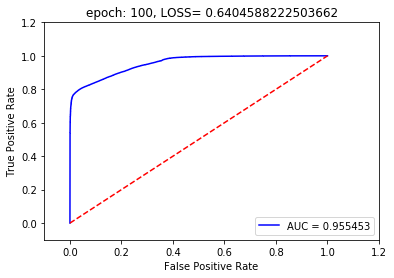

In [19]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y,pred_y)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('epoch: {}, LOSS= {}'.format(epoch_i, i_loss))
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Performance on the Validation set

In [20]:
model.eval()

UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (2): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (3): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(

Validation batch: 0, LOSS=0.78077232837677, ROC_AUC=0.947748846792954 


/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


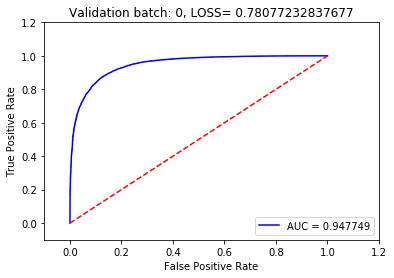

Validation batch: 1, LOSS=0.7883051037788391, ROC_AUC=0.9492310726222464 


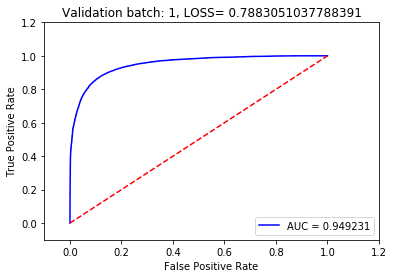

Validation batch: 2, LOSS=0.9393703937530518, ROC_AUC=0.9294965637529725 


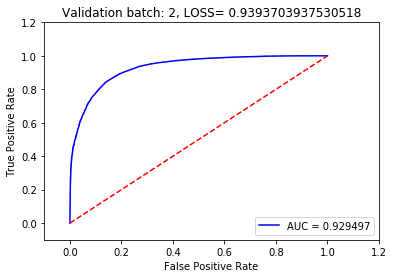

Validation batch: 3, LOSS=0.7034144401550293, ROC_AUC=0.9486699882649757 


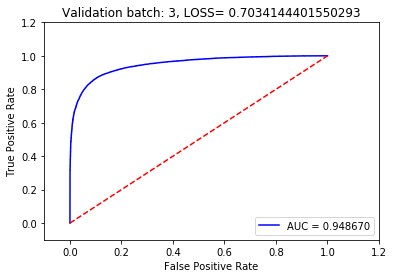

Validation batch: 4, LOSS=0.8729674816131592, ROC_AUC=0.9382149259617252 


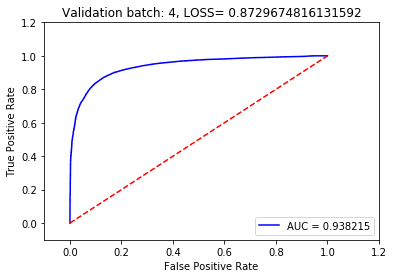

Validation batch: 5, LOSS=0.65636146068573, ROC_AUC=0.954822289164744 


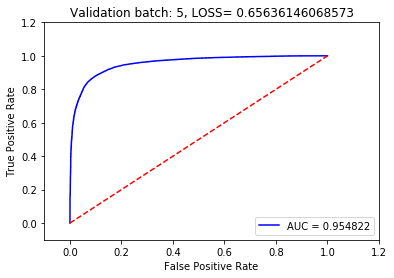

Validation batch: 6, LOSS=1.3401427268981934, ROC_AUC=0.9011277759066825 


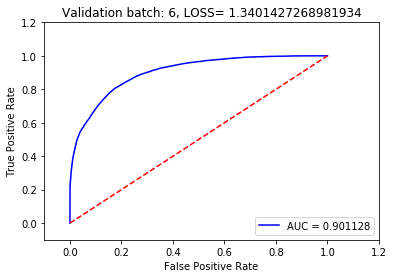

Validation batch: 7, LOSS=0.8272147178649902, ROC_AUC=0.9329404858868643 


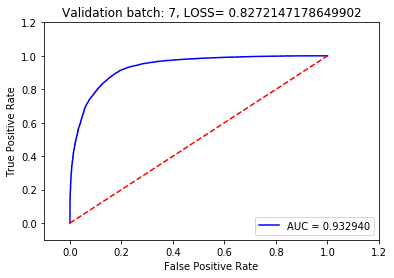

Validation batch: 8, LOSS=0.7783975005149841, ROC_AUC=0.9475685071558788 


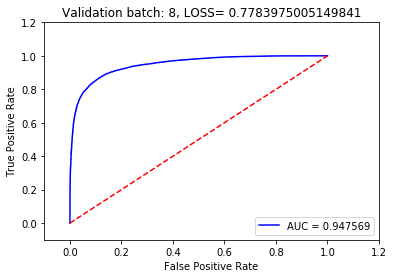

Validation batch: 9, LOSS=0.8745586276054382, ROC_AUC=0.9324606869297807 


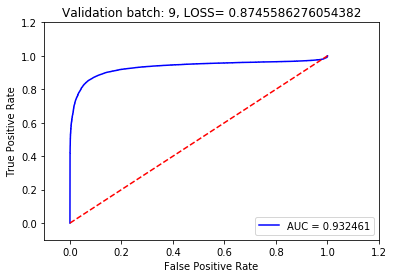

Validation batch: 10, LOSS=0.8440055847167969, ROC_AUC=0.9364406755405348 


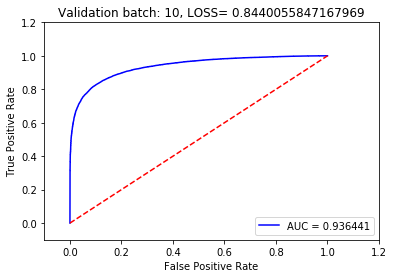

Validation batch: 11, LOSS=0.7369390726089478, ROC_AUC=0.9343483646705006 


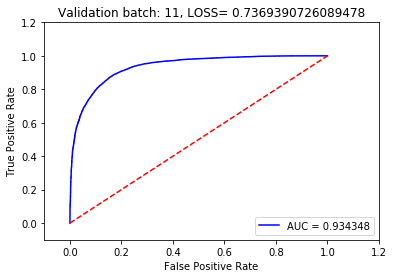

Validation batch: 12, LOSS=0.7526015639305115, ROC_AUC=0.9545677241625494 


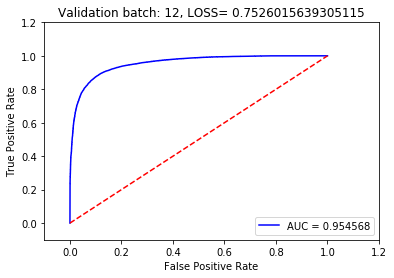

Validation batch: 13, LOSS=0.9333487749099731, ROC_AUC=0.9286954381059604 


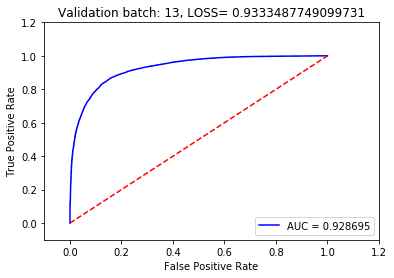

Validation batch: 14, LOSS=0.6993255615234375, ROC_AUC=0.9572112896214139 


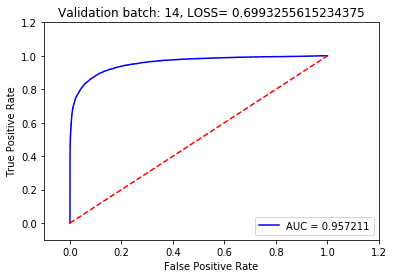

Validation batch: 15, LOSS=0.9121631383895874, ROC_AUC=0.932967699758292 


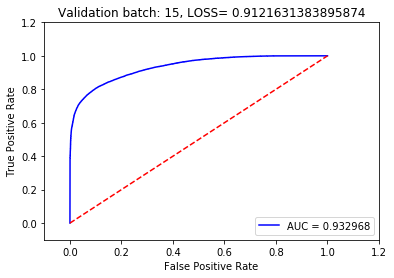

Validation batch: 16, LOSS=0.8933917284011841, ROC_AUC=0.9291024255325518 


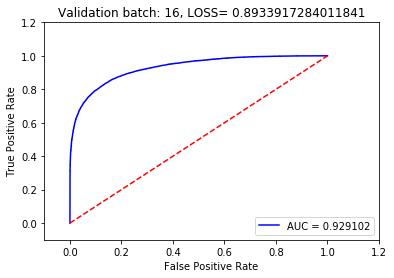

Validation batch: 17, LOSS=1.2284762859344482, ROC_AUC=0.9137137753552633 


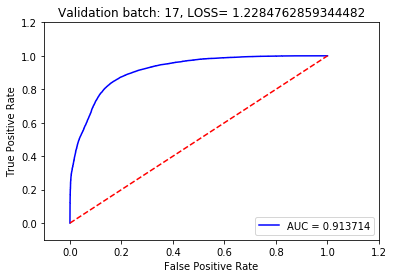

Validation batch: 18, LOSS=0.8350095748901367, ROC_AUC=0.9482922364190329 


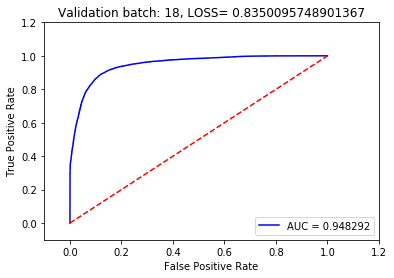

Validation batch: 19, LOSS=1.2934529781341553, ROC_AUC=0.8862463653470073 


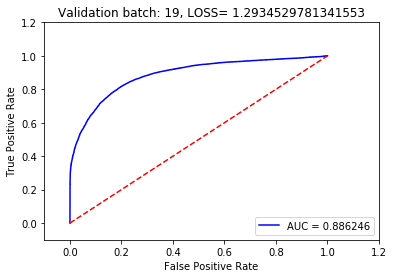

Validation batch: 20, LOSS=0.6333639621734619, ROC_AUC=0.9633352684967903 


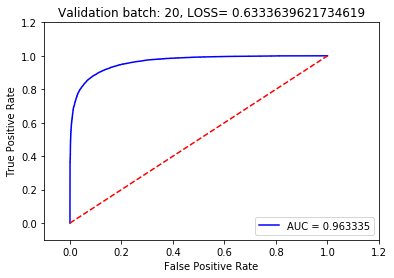

Validation batch: 21, LOSS=0.8692514896392822, ROC_AUC=0.9330870778741952 


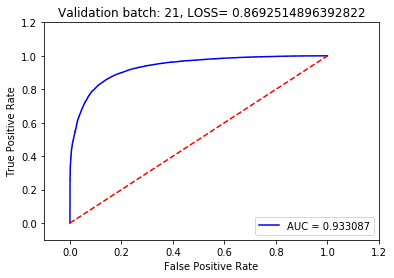

Validation batch: 22, LOSS=0.6864367127418518, ROC_AUC=0.9541743931026393 


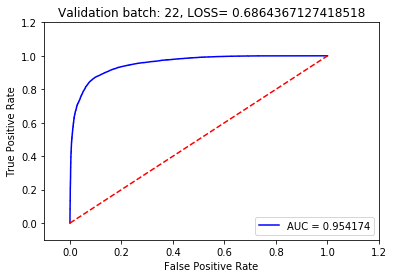

Validation batch: 23, LOSS=1.731032133102417, ROC_AUC=0.8396739213181884 


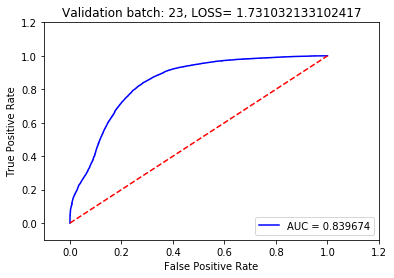

Validation batch: 24, LOSS=0.8097548484802246, ROC_AUC=0.9447560890503871 


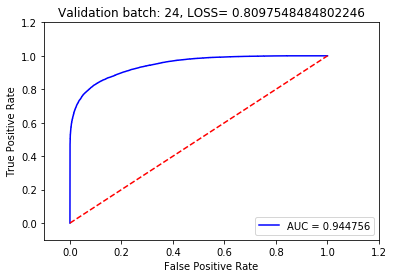

Validation batch: 25, LOSS=0.959355890750885, ROC_AUC=0.9282979308418687 


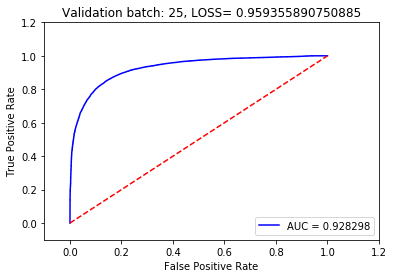

Validation batch: 26, LOSS=0.8890581727027893, ROC_AUC=0.9245046401220489 


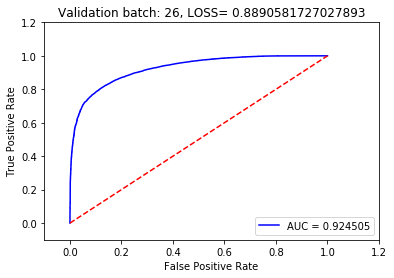

Validation batch: 27, LOSS=0.8962513208389282, ROC_AUC=0.9268166951775254 


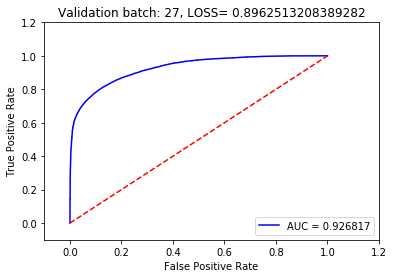

Validation batch: 28, LOSS=1.462695598602295, ROC_AUC=0.8529232596438039 


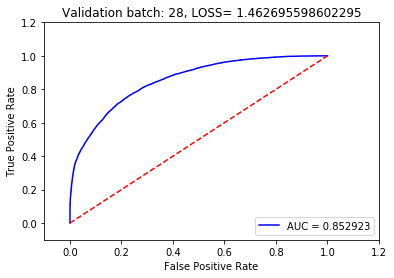

Validation batch: 29, LOSS=1.0151528120040894, ROC_AUC=0.9287493551163085 


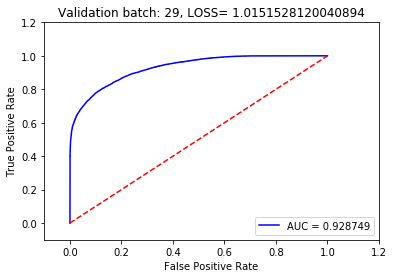

Validation batch: 30, LOSS=1.0165156126022339, ROC_AUC=0.9189745782569162 


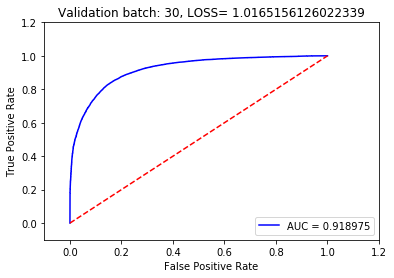

Validation batch: 31, LOSS=0.9091618061065674, ROC_AUC=0.9310523704372727 


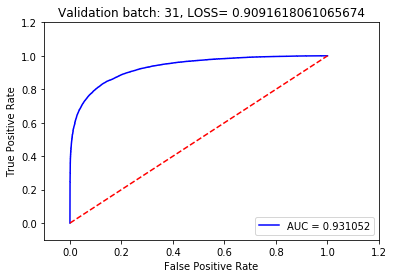

Validation batch: 32, LOSS=1.0373828411102295, ROC_AUC=0.9362562532821093 


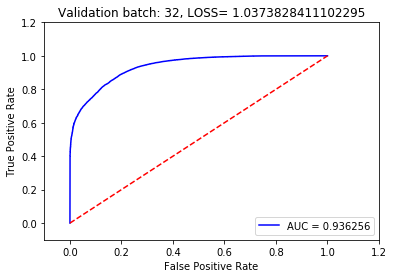

Validation batch: 33, LOSS=1.184922695159912, ROC_AUC=0.9124329361895835 


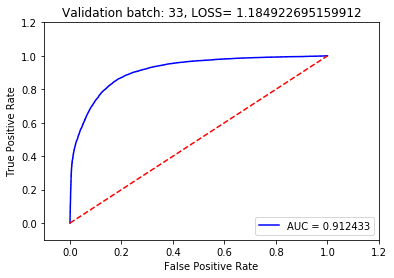

Validation batch: 34, LOSS=0.6109942197799683, ROC_AUC=0.9497479470074347 


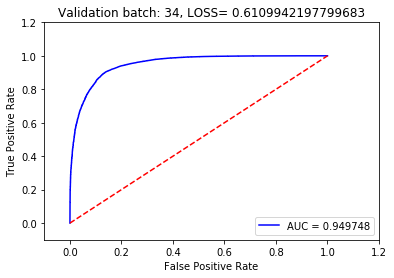

Validation batch: 35, LOSS=0.7330543398857117, ROC_AUC=0.9467782080661172 


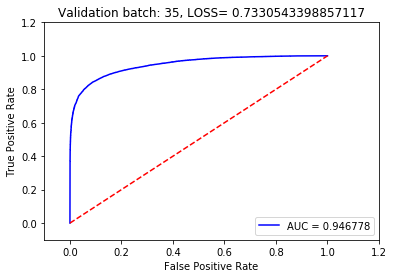

Validation batch: 36, LOSS=1.0560524463653564, ROC_AUC=0.9309608090752762 


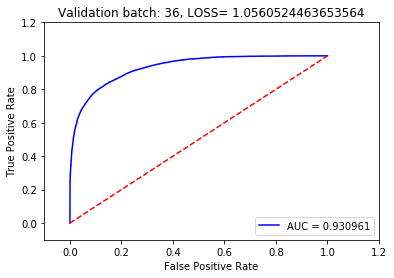

Validation batch: 37, LOSS=0.8605313301086426, ROC_AUC=0.9333059291241015 


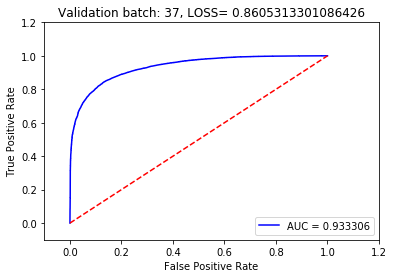

Validation batch: 38, LOSS=1.535028100013733, ROC_AUC=0.8756042410615016 


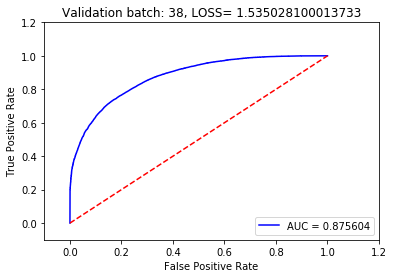

Validation batch: 39, LOSS=1.080567479133606, ROC_AUC=0.919639745527574 


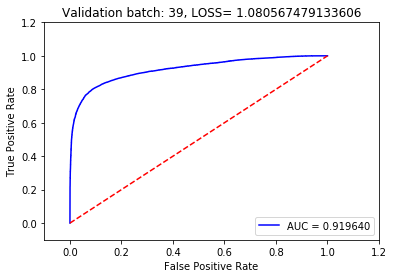

Validation batch: 40, LOSS=1.4816584587097168, ROC_AUC=0.8398066550715065 


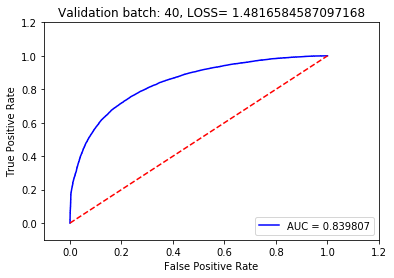

Validation batch: 41, LOSS=1.5835199356079102, ROC_AUC=0.8656823588591399 


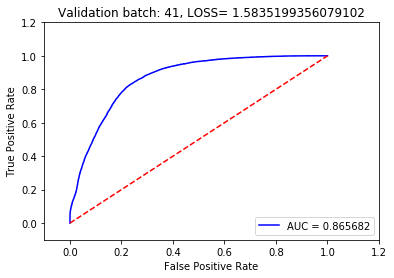

Validation batch: 42, LOSS=1.0605493783950806, ROC_AUC=0.8800377300380487 


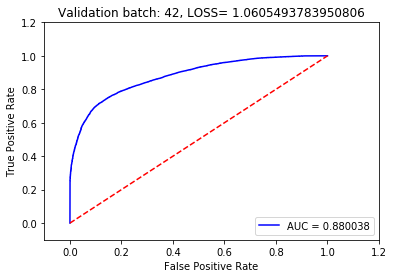

Validation batch: 43, LOSS=1.0728323459625244, ROC_AUC=0.8881644892303155 


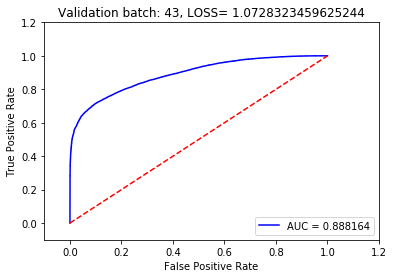

Validation batch: 44, LOSS=1.2752606868743896, ROC_AUC=0.914378383657551 


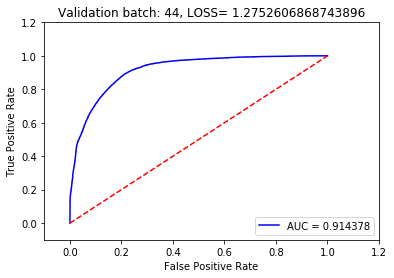

Validation batch: 45, LOSS=1.2355971336364746, ROC_AUC=0.8851579665436942 


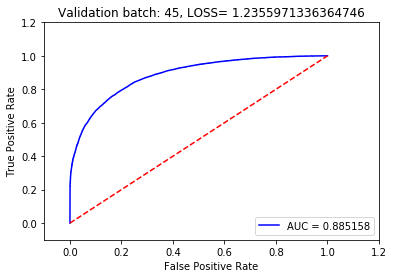

Validation batch: 46, LOSS=1.395775318145752, ROC_AUC=0.8733101312136673 


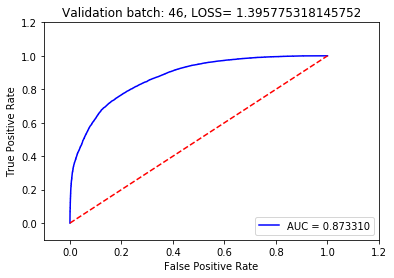

Validation batch: 47, LOSS=1.0363025665283203, ROC_AUC=0.9104091845347151 


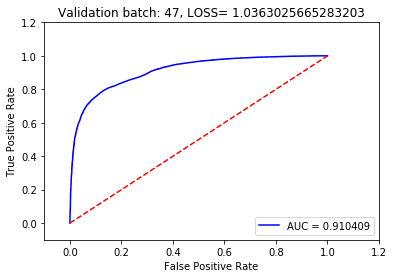

Validation batch: 48, LOSS=0.8119258880615234, ROC_AUC=0.9334670466560028 


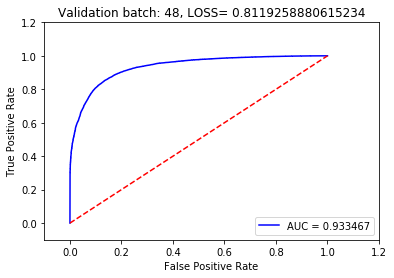

Validation batch: 49, LOSS=1.151319980621338, ROC_AUC=0.8981756169365201 


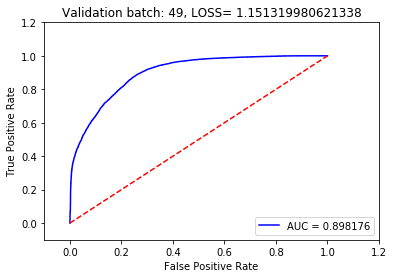

Validation batch: 50, LOSS=1.5887055397033691, ROC_AUC=0.8578251507027762 


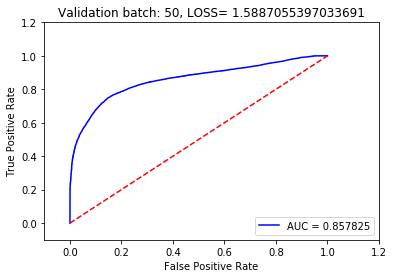

Validation batch: 51, LOSS=1.4141654968261719, ROC_AUC=0.8760336027723478 


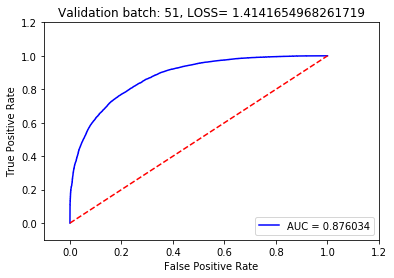

Validation batch: 52, LOSS=0.9379048347473145, ROC_AUC=0.9371809557521997 


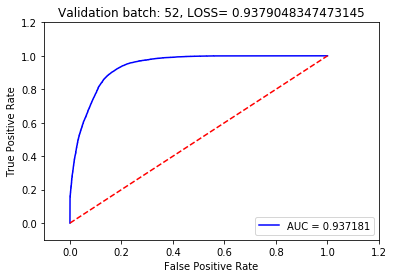

Validation batch: 53, LOSS=1.0472017526626587, ROC_AUC=0.8993688739696828 


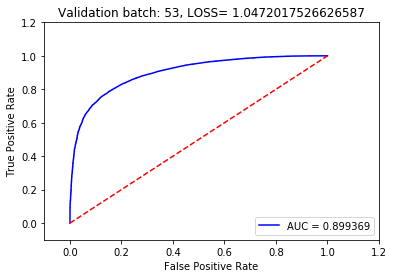

Validation batch: 54, LOSS=1.1905081272125244, ROC_AUC=0.8772320334652333 


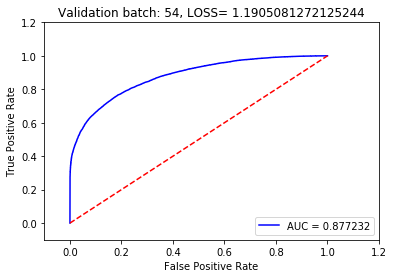

Validation batch: 55, LOSS=1.2408595085144043, ROC_AUC=0.8969438580720898 


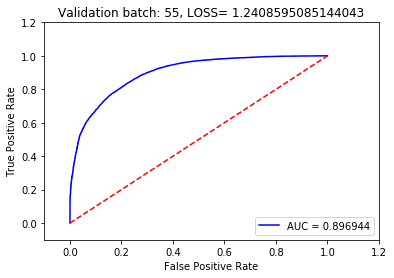

Validation batch: 56, LOSS=1.3118048906326294, ROC_AUC=0.8575475783474233 


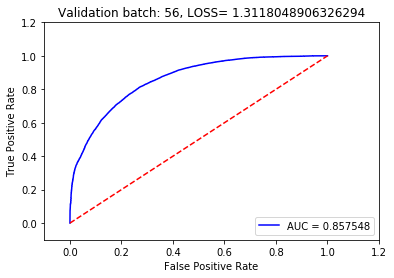

Validation batch: 57, LOSS=0.8072773218154907, ROC_AUC=0.9520645407026421 


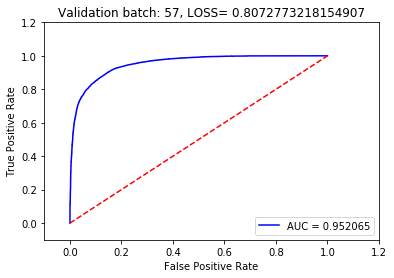

Validation batch: 58, LOSS=1.303055763244629, ROC_AUC=0.8425277428701003 


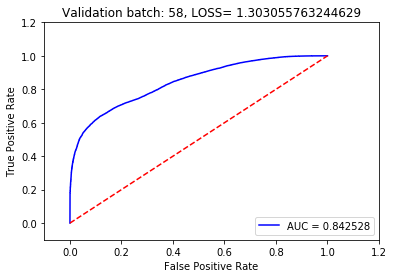

Validation batch: 59, LOSS=1.2034692764282227, ROC_AUC=0.9073514756646572 


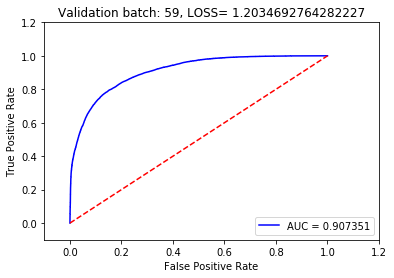

Validation batch: 60, LOSS=1.2250697612762451, ROC_AUC=0.8928741507664707 


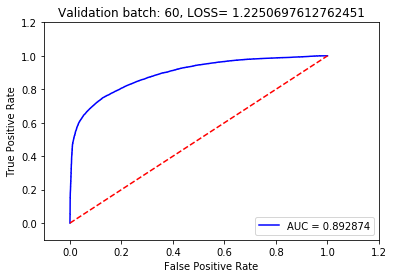

Validation batch: 61, LOSS=0.6726580262184143, ROC_AUC=0.9553243881203893 


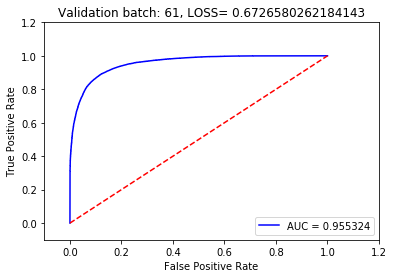

Validation batch: 62, LOSS=0.8544875979423523, ROC_AUC=0.9285472751998614 


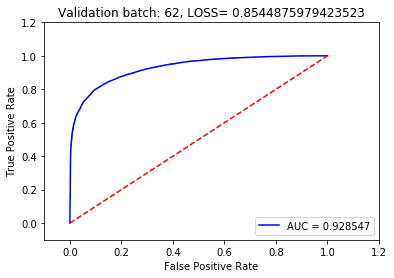

Validation batch: 63, LOSS=0.9235855340957642, ROC_AUC=0.9290340506671203 


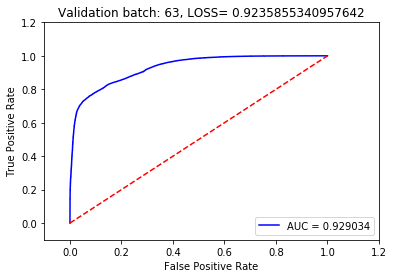

Validation batch: 64, LOSS=1.0581495761871338, ROC_AUC=0.9088373466987234 


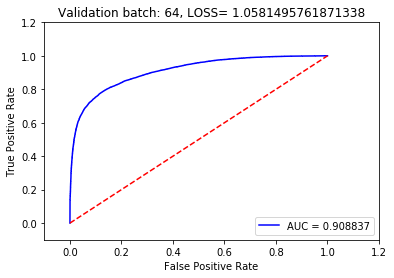

Validation batch: 65, LOSS=0.952885627746582, ROC_AUC=0.921876013156594 


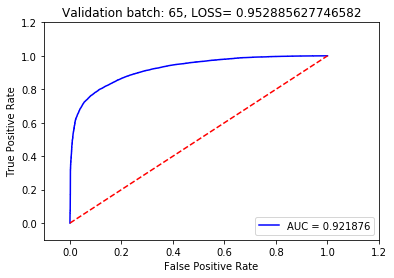

Validation batch: 66, LOSS=1.4515013694763184, ROC_AUC=0.8630492132495932 


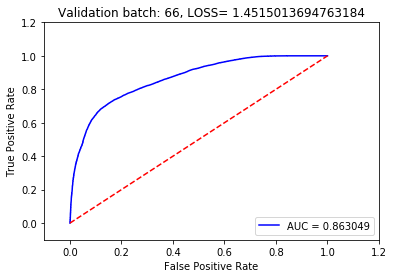

Validation batch: 67, LOSS=1.7573801279067993, ROC_AUC=0.8696628051870441 


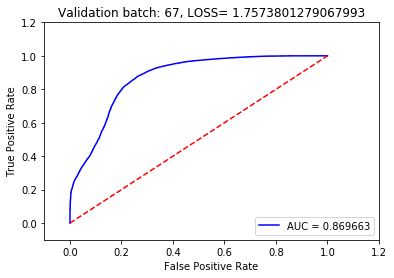

Validation batch: 68, LOSS=1.201920986175537, ROC_AUC=0.87202141294516 


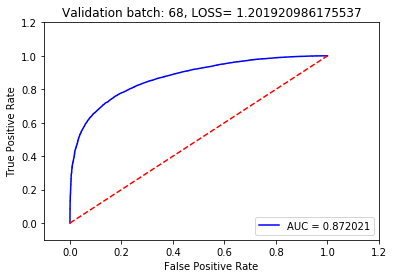

Validation batch: 69, LOSS=0.7953460216522217, ROC_AUC=0.9311525423095047 


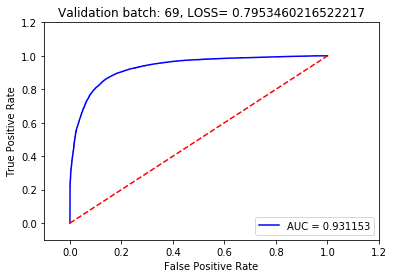

Validation batch: 70, LOSS=1.4539086818695068, ROC_AUC=0.8438100885777526 


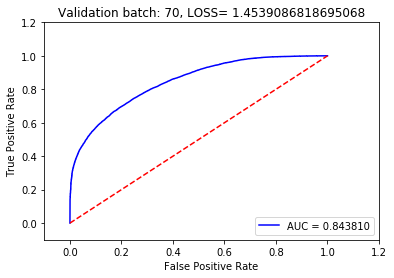

Validation batch: 71, LOSS=1.131345510482788, ROC_AUC=0.8939217813232677 


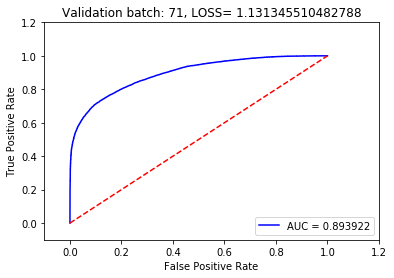

Validation batch: 72, LOSS=0.993005633354187, ROC_AUC=0.9187100239467725 


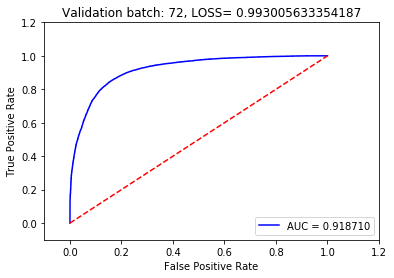

Validation batch: 73, LOSS=1.541975736618042, ROC_AUC=0.8394548591641852 


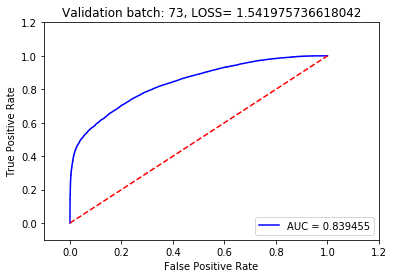

Validation batch: 74, LOSS=1.1646056175231934, ROC_AUC=0.8922418242601 


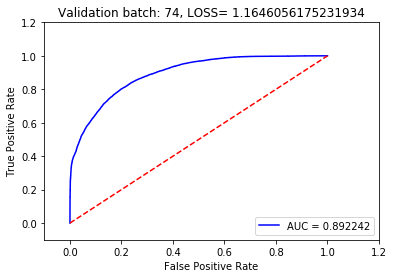

Validation batch: 75, LOSS=1.372689962387085, ROC_AUC=0.8733649279377667 


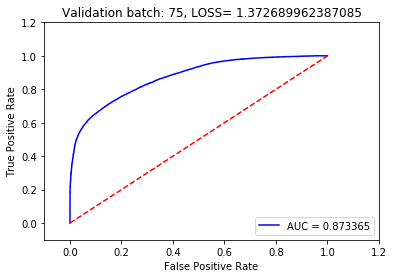

Validation batch: 76, LOSS=1.790016531944275, ROC_AUC=0.8241494208954707 


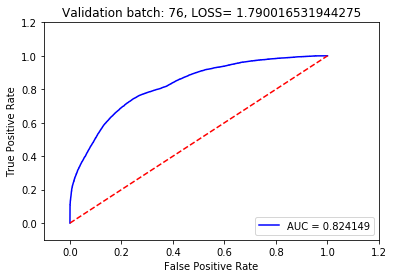

Validation batch: 77, LOSS=1.3373093605041504, ROC_AUC=0.8426121301511768 


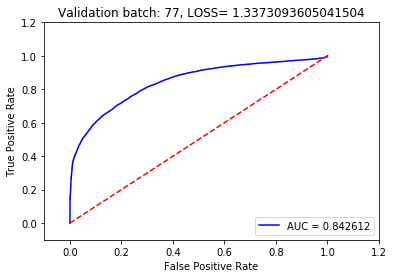

Validation batch: 78, LOSS=1.2339472770690918, ROC_AUC=0.8873304721048108 


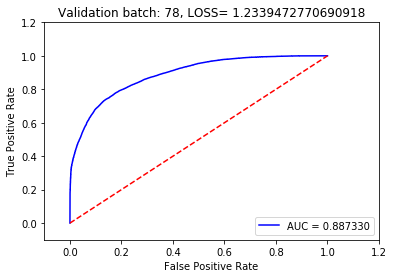

Validation batch: 79, LOSS=1.7324306964874268, ROC_AUC=0.824407466641506 


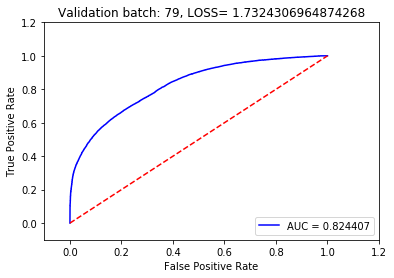

Validation batch: 80, LOSS=1.290726900100708, ROC_AUC=0.8805742938108141 


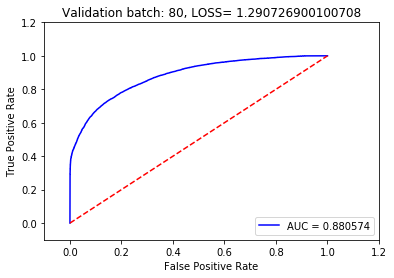

Validation batch: 81, LOSS=1.748291015625, ROC_AUC=0.8549891962975537 


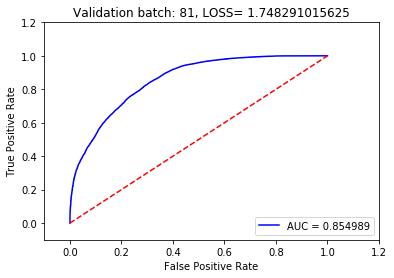

Validation batch: 82, LOSS=1.1821205615997314, ROC_AUC=0.8900171972298572 


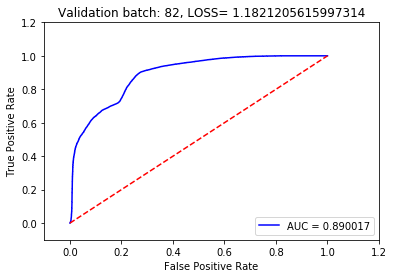

Validation batch: 83, LOSS=1.293189525604248, ROC_AUC=0.8897197394907396 


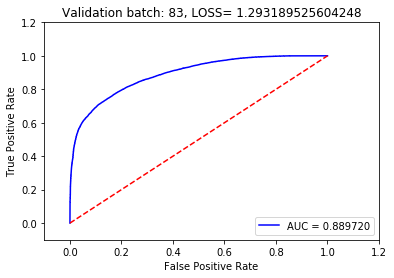

Validation batch: 84, LOSS=0.6601748466491699, ROC_AUC=0.9450027223635825 


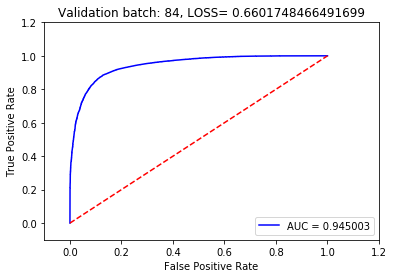

Validation batch: 85, LOSS=1.2360180616378784, ROC_AUC=0.8632581431236251 


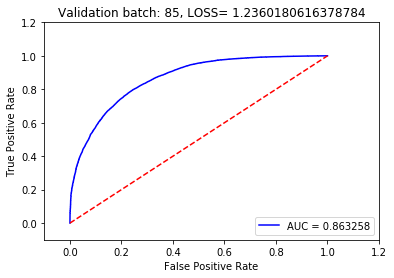

Validation batch: 86, LOSS=1.1016435623168945, ROC_AUC=0.8589231011610724 


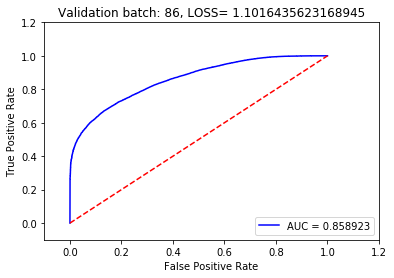

Validation batch: 87, LOSS=1.3976104259490967, ROC_AUC=0.8648037642044097 


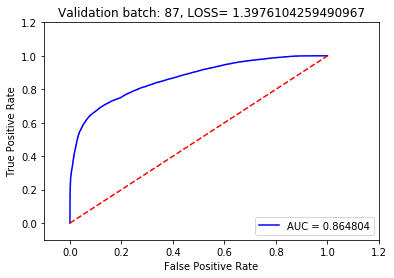

Validation batch: 88, LOSS=1.497056007385254, ROC_AUC=0.8522823859551485 


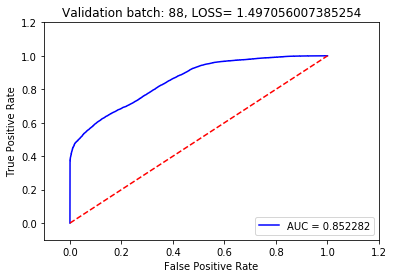

Validation batch: 89, LOSS=1.3607628345489502, ROC_AUC=0.8908596809230122 


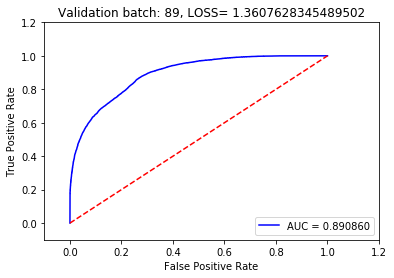

Validation batch: 90, LOSS=1.7548072338104248, ROC_AUC=0.8197806242215979 


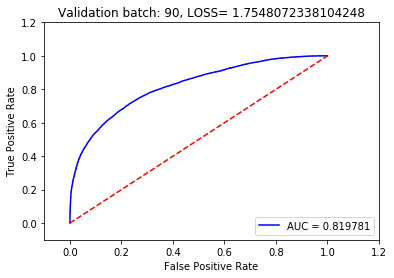

Validation batch: 91, LOSS=0.9588050246238708, ROC_AUC=0.88959732864728 


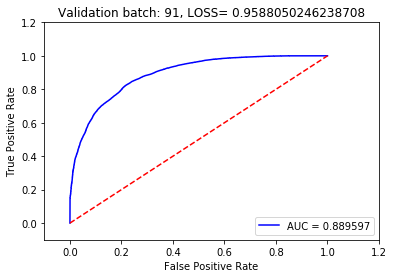

Validation batch: 92, LOSS=1.2362486124038696, ROC_AUC=0.8610074397270235 


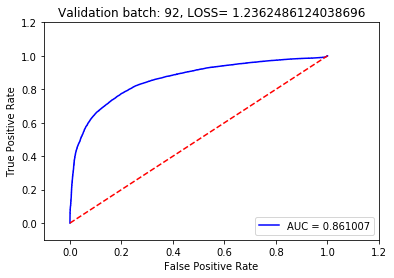

Validation batch: 93, LOSS=1.622976541519165, ROC_AUC=0.7913782582147226 


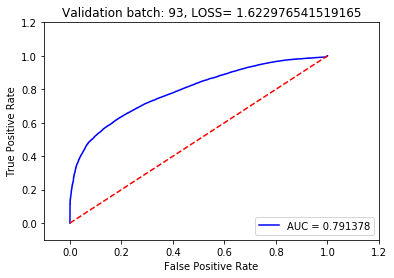

Validation batch: 94, LOSS=1.4979701042175293, ROC_AUC=0.8284519196843412 


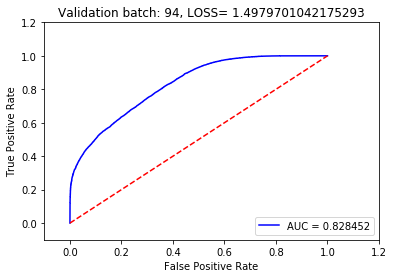

Validation batch: 95, LOSS=1.0753041505813599, ROC_AUC=0.8863712369300767 


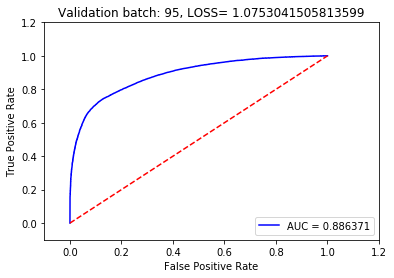

Validation batch: 96, LOSS=1.1199142932891846, ROC_AUC=0.8612321629674903 


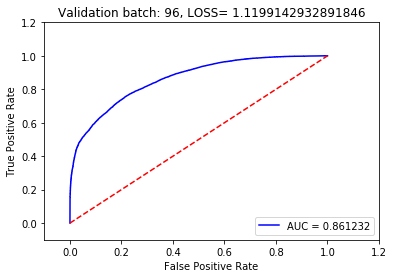

Validation batch: 97, LOSS=0.9777748584747314, ROC_AUC=0.9148982103477772 


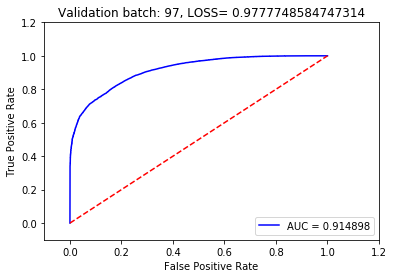

Validation batch: 98, LOSS=1.3064854145050049, ROC_AUC=0.8721159425218039 


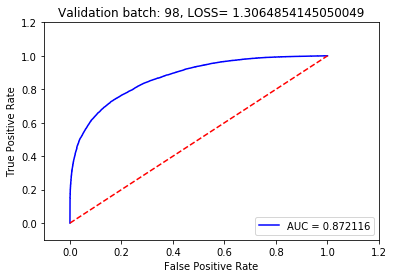

Validation batch: 99, LOSS=1.1654213666915894, ROC_AUC=0.897562224150836 


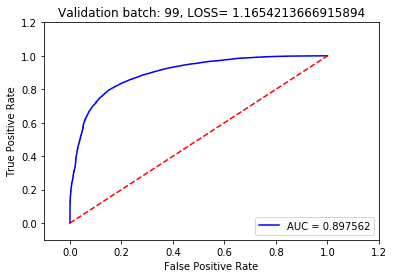

Validation batch: 100, LOSS=1.7894432544708252, ROC_AUC=0.7676677061390202 


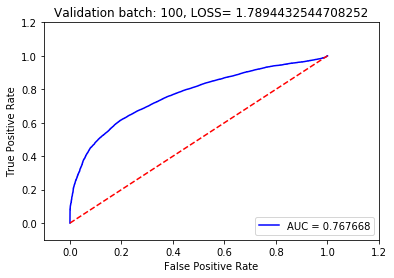

Validation batch: 101, LOSS=0.8140575885772705, ROC_AUC=0.9361172969964877 


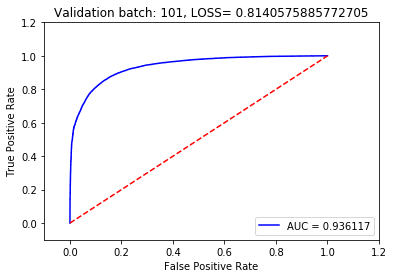

Validation batch: 102, LOSS=1.274250864982605, ROC_AUC=0.8902086649762208 


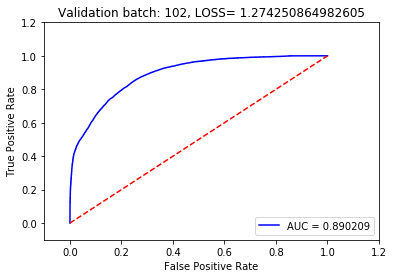

Validation batch: 103, LOSS=0.786857545375824, ROC_AUC=0.9298972377420884 


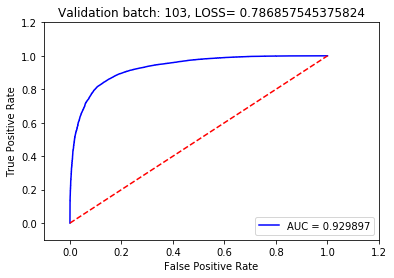

Validation batch: 104, LOSS=1.475795030593872, ROC_AUC=0.8671888230866929 


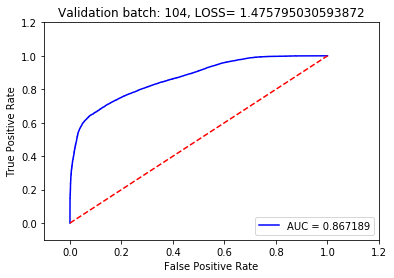

Validation batch: 105, LOSS=1.400163173675537, ROC_AUC=0.8588415377854314 


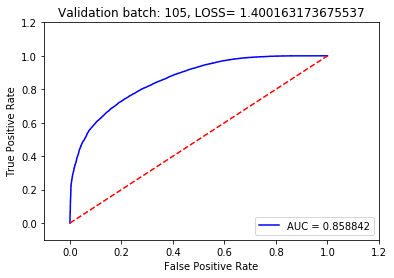

Validation batch: 106, LOSS=1.3898227214813232, ROC_AUC=0.8171528561826731 


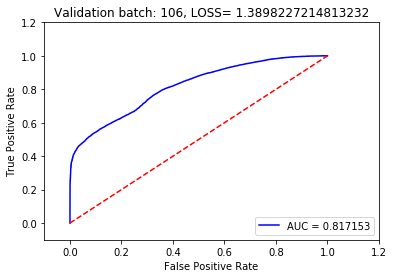

Validation batch: 107, LOSS=0.9071832895278931, ROC_AUC=0.9042661568190233 


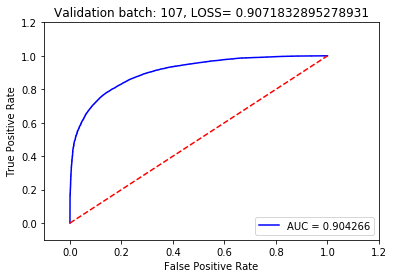

Validation batch: 108, LOSS=1.3412597179412842, ROC_AUC=0.8740372565086478 


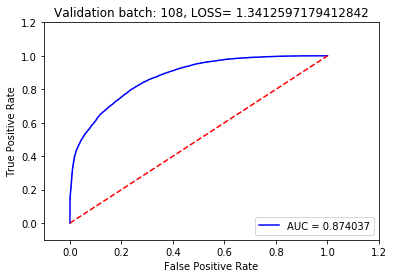

Validation batch: 109, LOSS=1.1876929998397827, ROC_AUC=0.857112621206491 


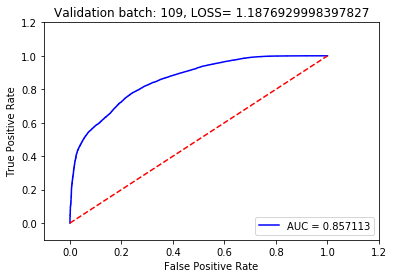

Validation batch: 110, LOSS=0.9718634486198425, ROC_AUC=0.912640282405258 


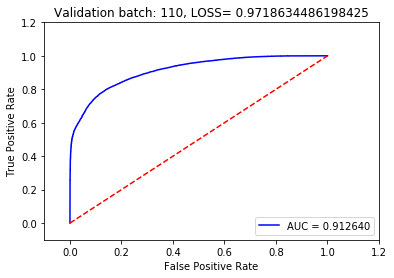

Validation batch: 111, LOSS=1.4134159088134766, ROC_AUC=0.8815615280539353 


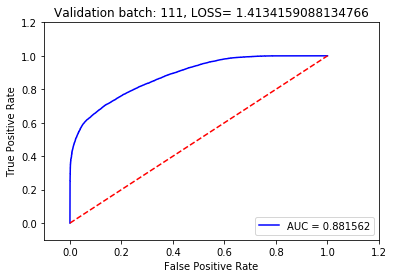

Validation batch: 112, LOSS=1.3050352334976196, ROC_AUC=0.8590408681765145 


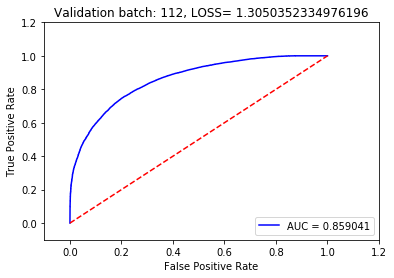

Validation batch: 113, LOSS=1.3445873260498047, ROC_AUC=0.864631478111505 


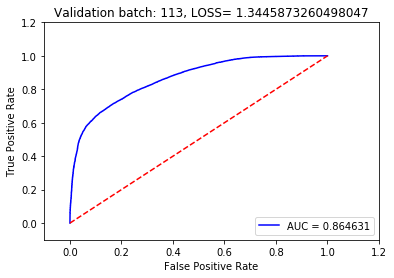

Validation batch: 114, LOSS=0.9697492122650146, ROC_AUC=0.8980373325285389 


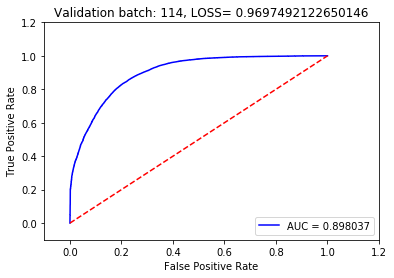

Validation batch: 115, LOSS=1.4627915620803833, ROC_AUC=0.8479843610465311 


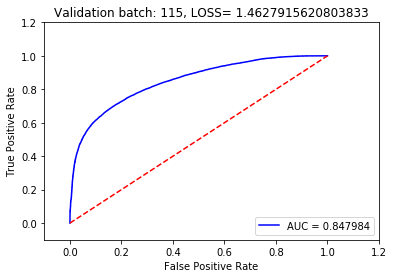

Validation batch: 116, LOSS=0.9048733711242676, ROC_AUC=0.9164588689762116 


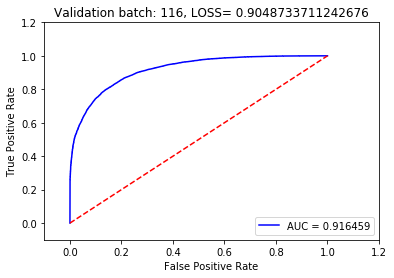

Validation batch: 117, LOSS=0.9254171848297119, ROC_AUC=0.9108137388102968 


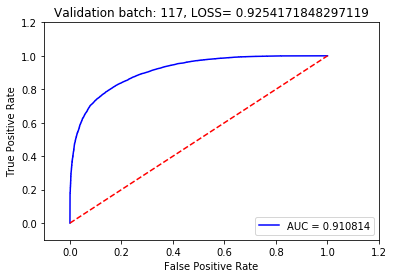

Validation batch: 118, LOSS=1.4019255638122559, ROC_AUC=0.8699198902510228 


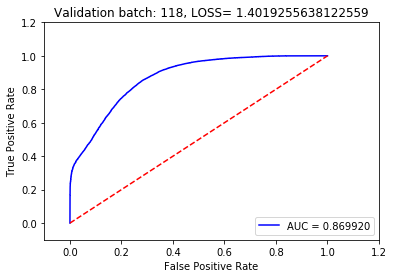

Validation batch: 119, LOSS=1.1174311637878418, ROC_AUC=0.8842123396108916 


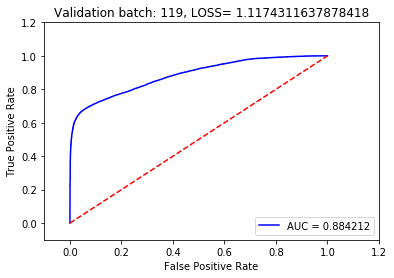

Validation batch: 120, LOSS=0.7918038368225098, ROC_AUC=0.9314721124664284 


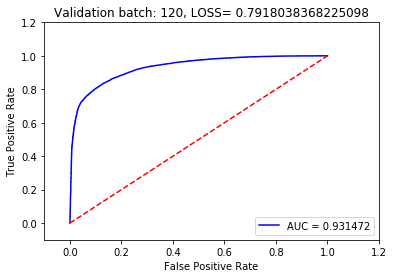

Validation batch: 121, LOSS=1.6934504508972168, ROC_AUC=0.8197130353344392 


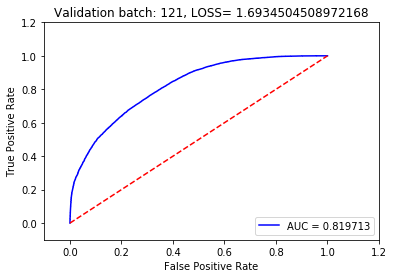

Validation batch: 122, LOSS=1.1645551919937134, ROC_AUC=0.9025589595687864 


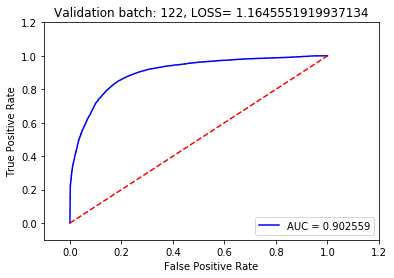

Validation batch: 123, LOSS=1.2055857181549072, ROC_AUC=0.8891347943191829 


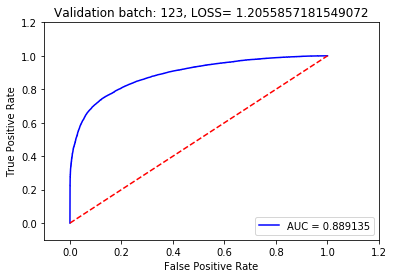

Validation batch: 124, LOSS=1.1094497442245483, ROC_AUC=0.9016714352357982 


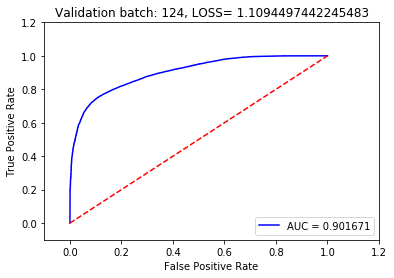

In [21]:
##### Validation data
## ground truth
gt_dl_val = DataLoader(gt_dataset_val, batch_size=bsize, shuffle=False)


## DG
dg_dl_val = DataLoader(dg_dataset_val, batch_size=bsize, shuffle=False)


# define a zipped object for iterating
zl = zip(dg_dl_val, gt_dl_val)

# some lists for plotting all batch ROC curves
all_fpr = []
all_tpr = []
all_thresh = []
all_roc_auc = []
for i_val, (inputs_, targets_) in enumerate(zl):

        # get the inputs
        #inputs, targets = variable(inputs_).cuda(), variable(targets_).cuda()
        inputs, targets = variable(inputs_), variable(targets_)
        inputs.to(device)
        targets.to(device)

        # evaluate
        outputs = model(inputs)
        
        # record loss
        v_loss = criterion(outputs, targets)
        
        # convert to numpy and get ROC params
        pred_y_val = outputs.cpu().data.numpy().squeeze().flatten()
        #pred_y_val[pred_y_val > 0] = 1.
        #pred_y_val[pred_y_val <=0] = 0.
        target_y_val = targets.cpu().data.numpy().flatten()
        tu = (v_loss, roc_auc_score(target_y_val,pred_y_val ))
        print ('Validation batch: {}, LOSS={}, ROC_AUC={} '.format(i_val, *tu))  

        # calculate FPR and TPR, and area-under-curve
        false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y_val,pred_y_val)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        
        # append to lists
        all_fpr.append(false_positive_rate)
        all_tpr.append(true_positive_rate)
        all_thresh.append(thresholds)
        all_roc_auc.append(roc_auc)

        plt.title('Validation batch: {}, LOSS= {}'.format(i_val, v_loss))
        plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([-0.1, 1.2])
        plt.ylim([-0.1, 1.2])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()





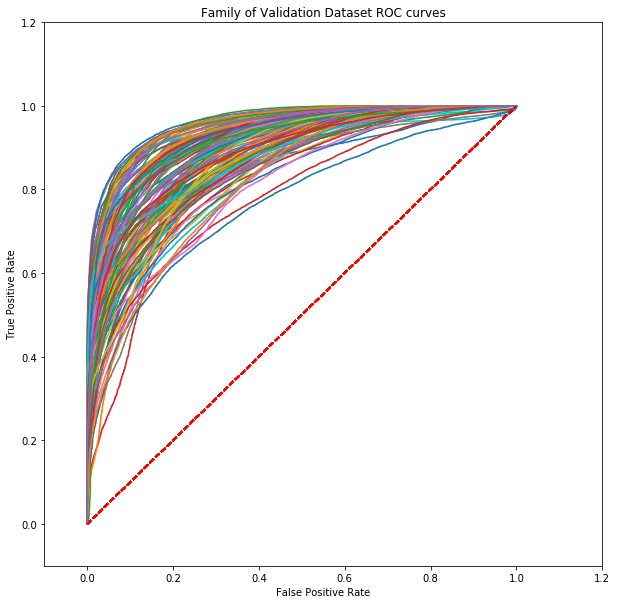

In [22]:
## plot all the validation dataset ROC curves
plt.figure(figsize=(10,10))
plt.title('Family of Validation Dataset ROC curves')
for ind in range(len(all_fpr)):
    
    plt.plot(all_fpr[ind], all_tpr[ind])
    #plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
#     plt.yscale('log')
#     plt.xscale('log')
    
plt.show()

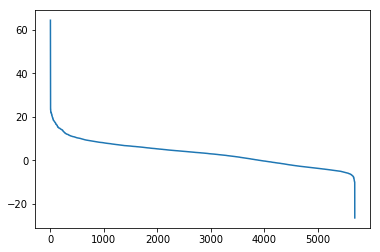

In [23]:
plt.plot(all_thresh[0])

In [24]:
model_path = 'runs/debug/MS_model_e{}_b{}_no_aug_GPUPAR.pt'.format(epoch_i, bsize)
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

save(epoch)

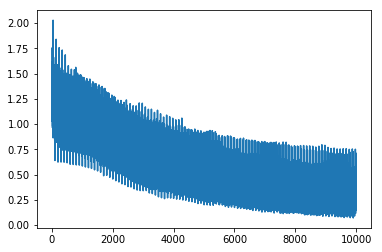

In [25]:
# plot the losses epoch losses from the last 66/100 epochs
# (forgot to record from epoch 0 since I was going in epoch chunks... it is faster with the GPU!!)
plt.plot([l.data.cpu().numpy() for l in losses])

/home/ubuntu/segmentation/IS_segmentation/utils.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return cuda(Variable(x, volatile=volatile))


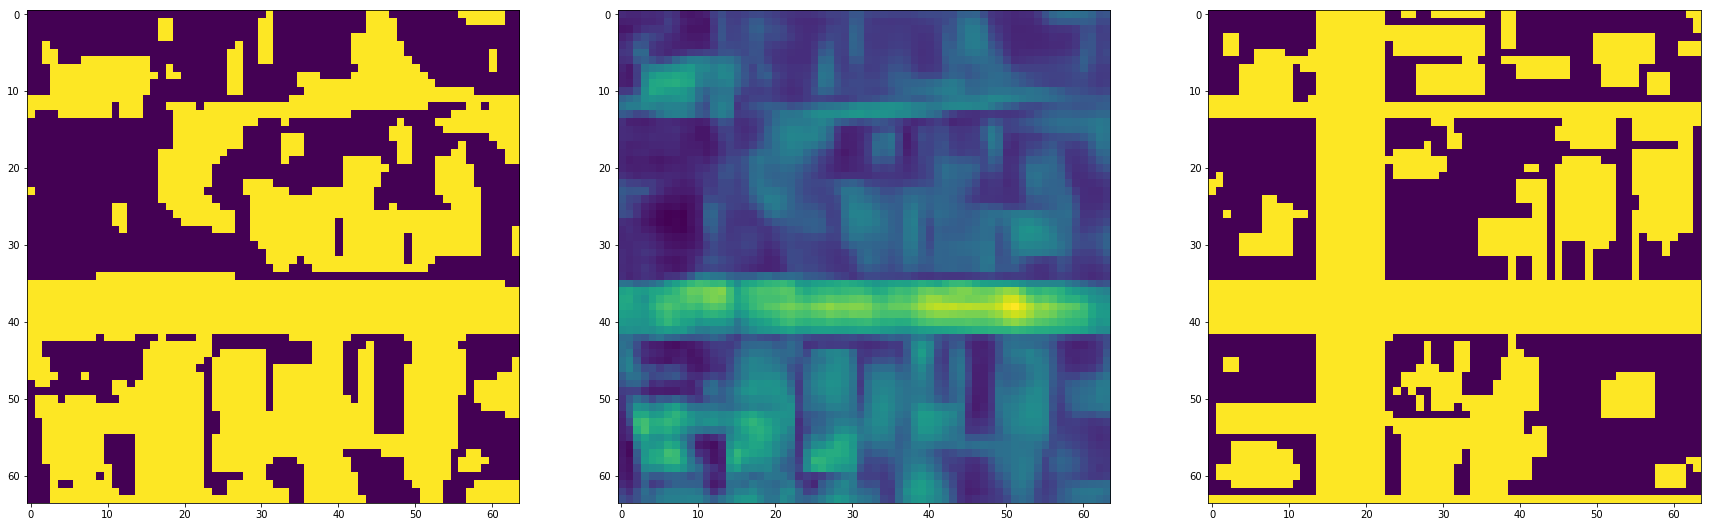

/home/ubuntu/anaconda3/envs/spatial_torch/lib/python3.5/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


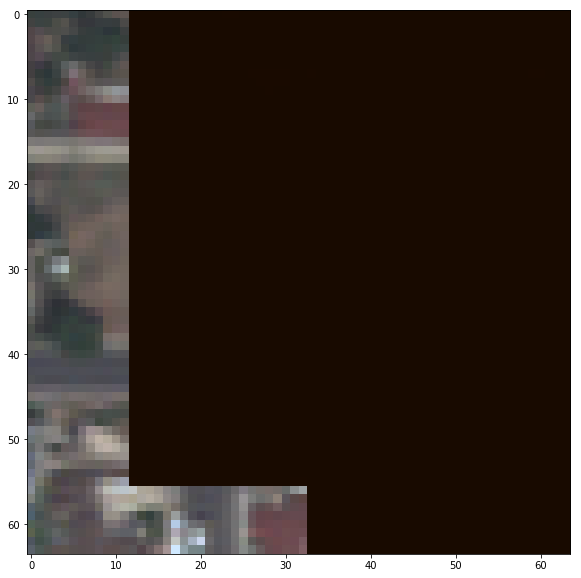

invalid argument 3: Source tensor must be contiguous at /opt/conda/conda-bld/pytorch_1532576276790/work/aten/src/THC/generic/THCTensorCopy.cpp:114


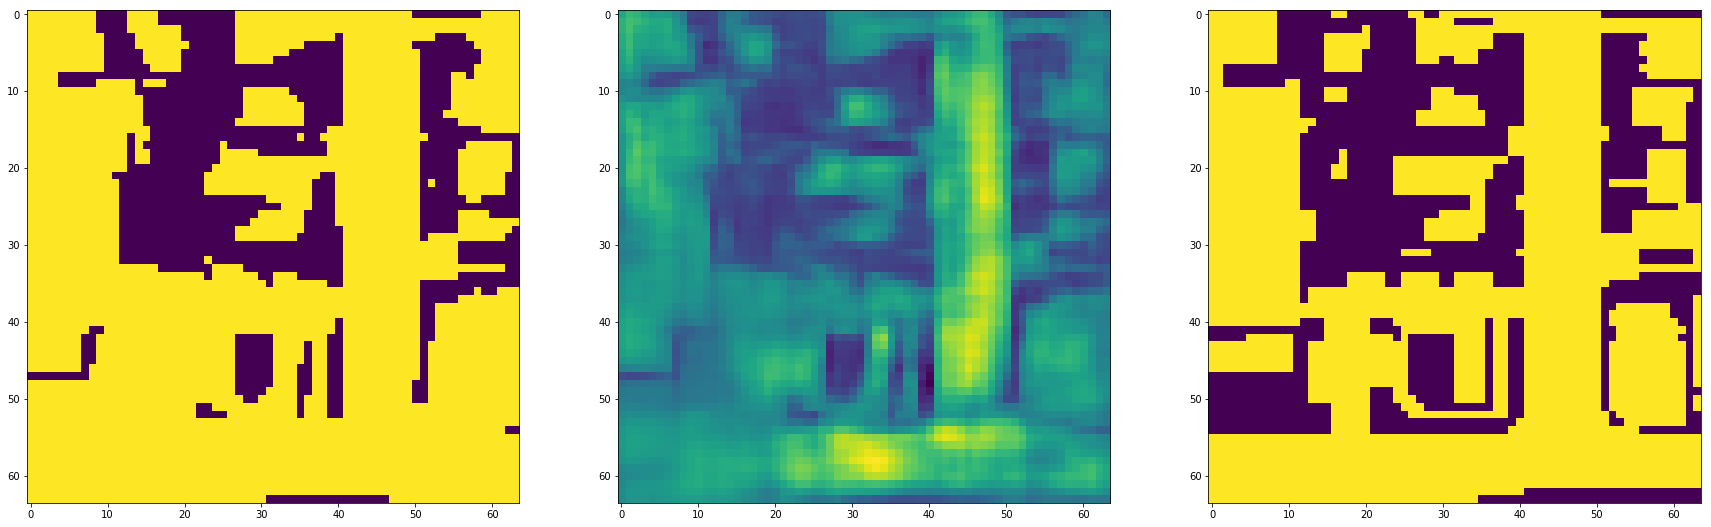

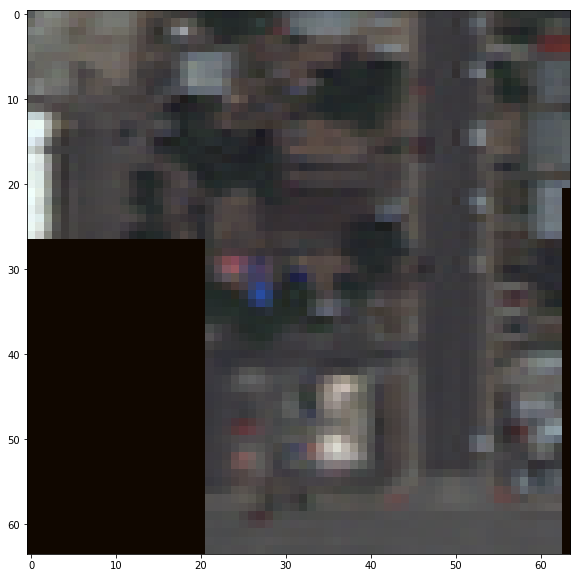

invalid argument 3: Source tensor must be contiguous at /opt/conda/conda-bld/pytorch_1532576276790/work/aten/src/THC/generic/THCTensorCopy.cpp:114


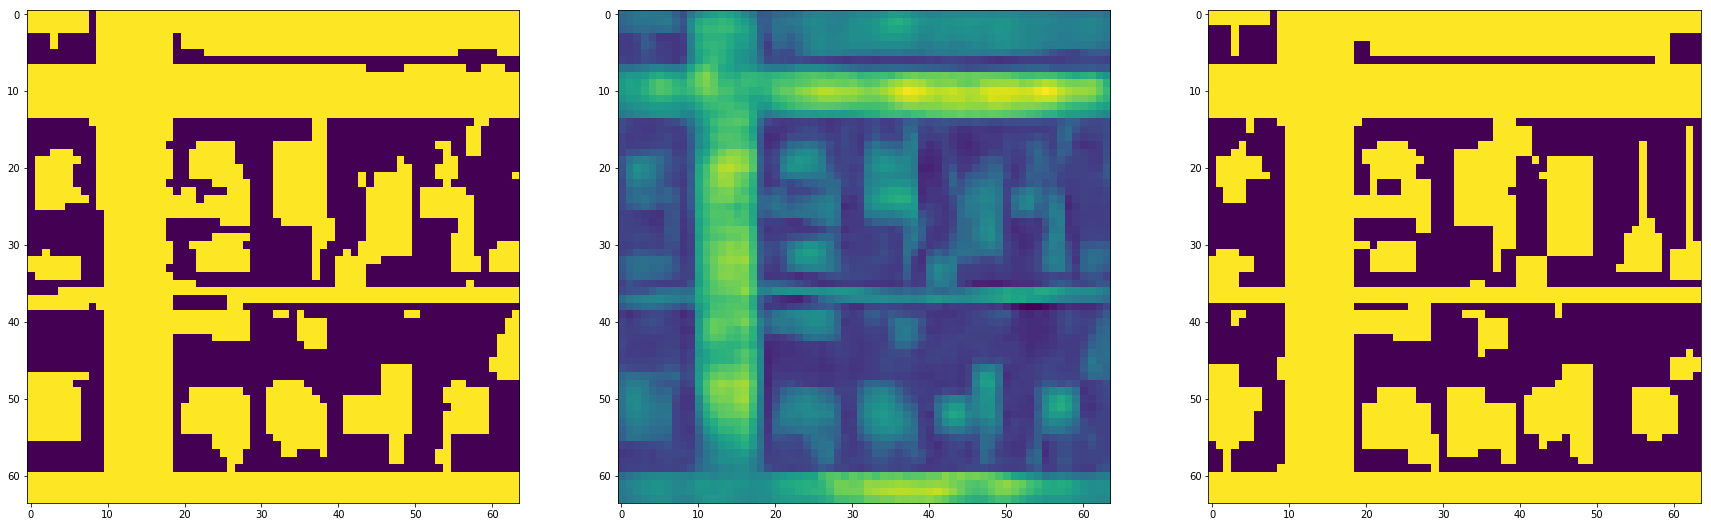

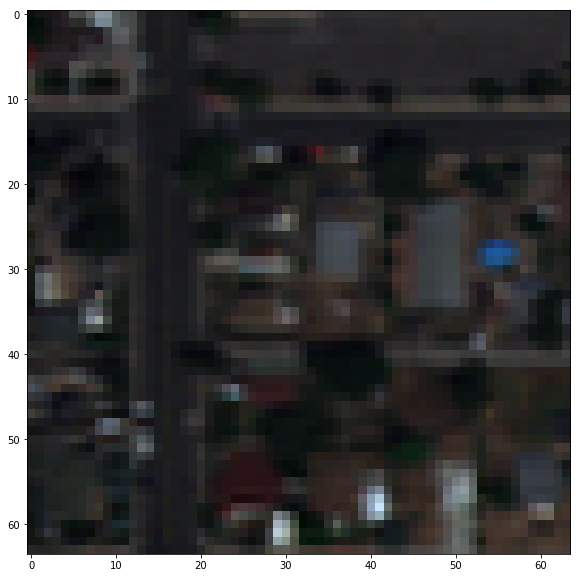

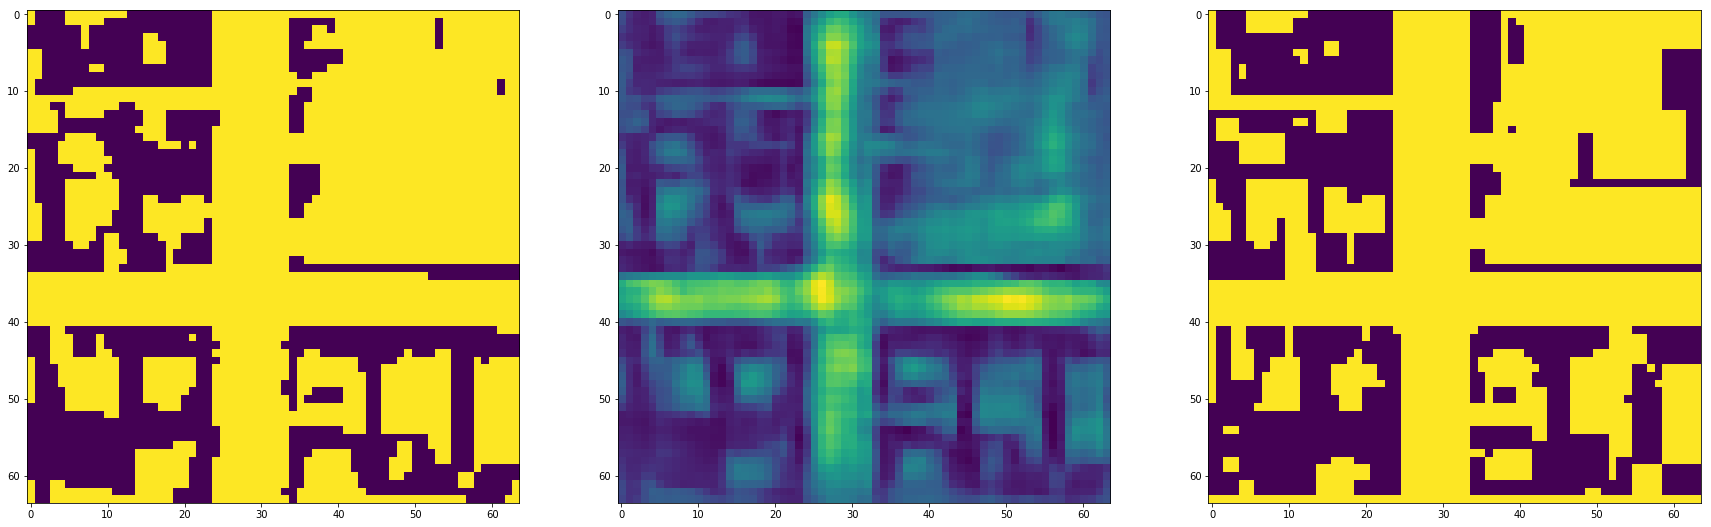

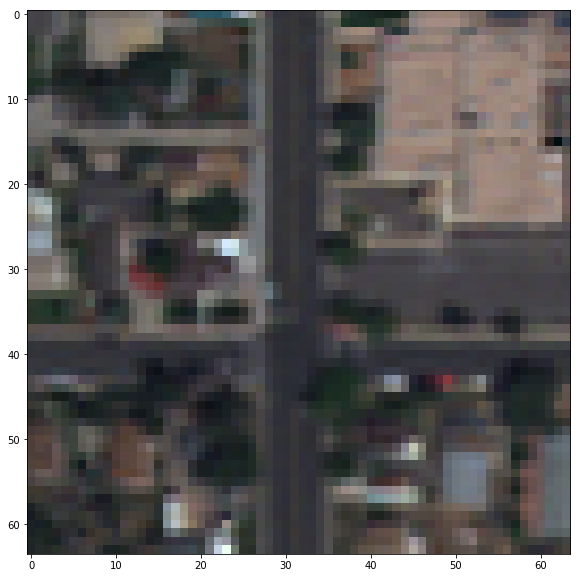

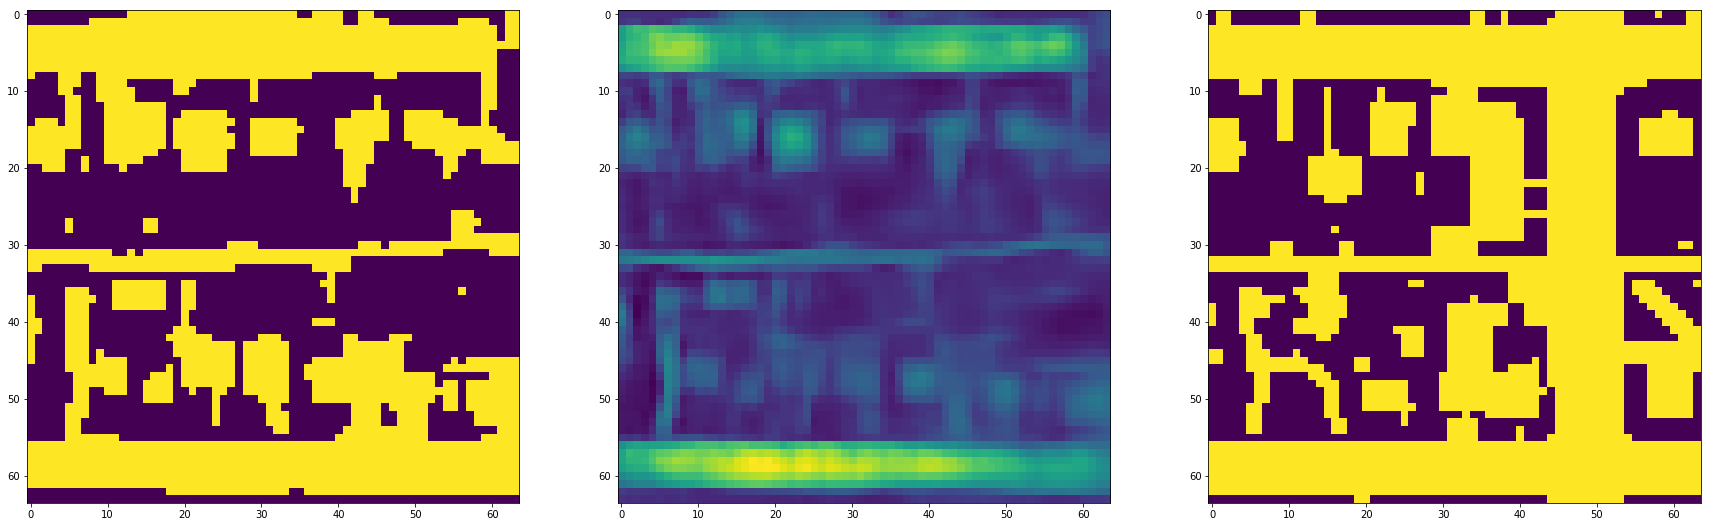

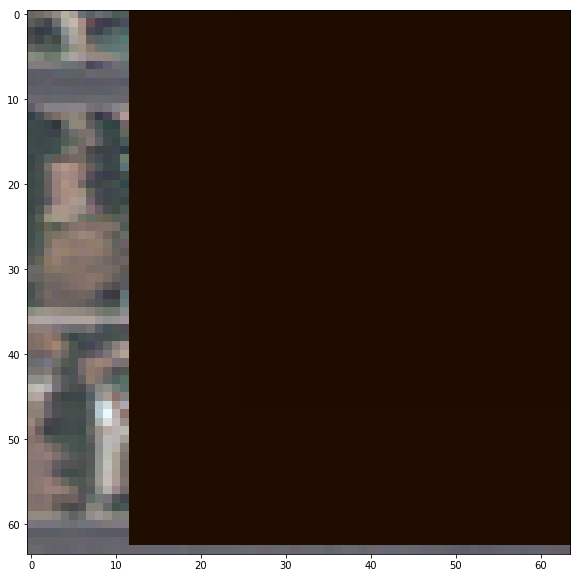

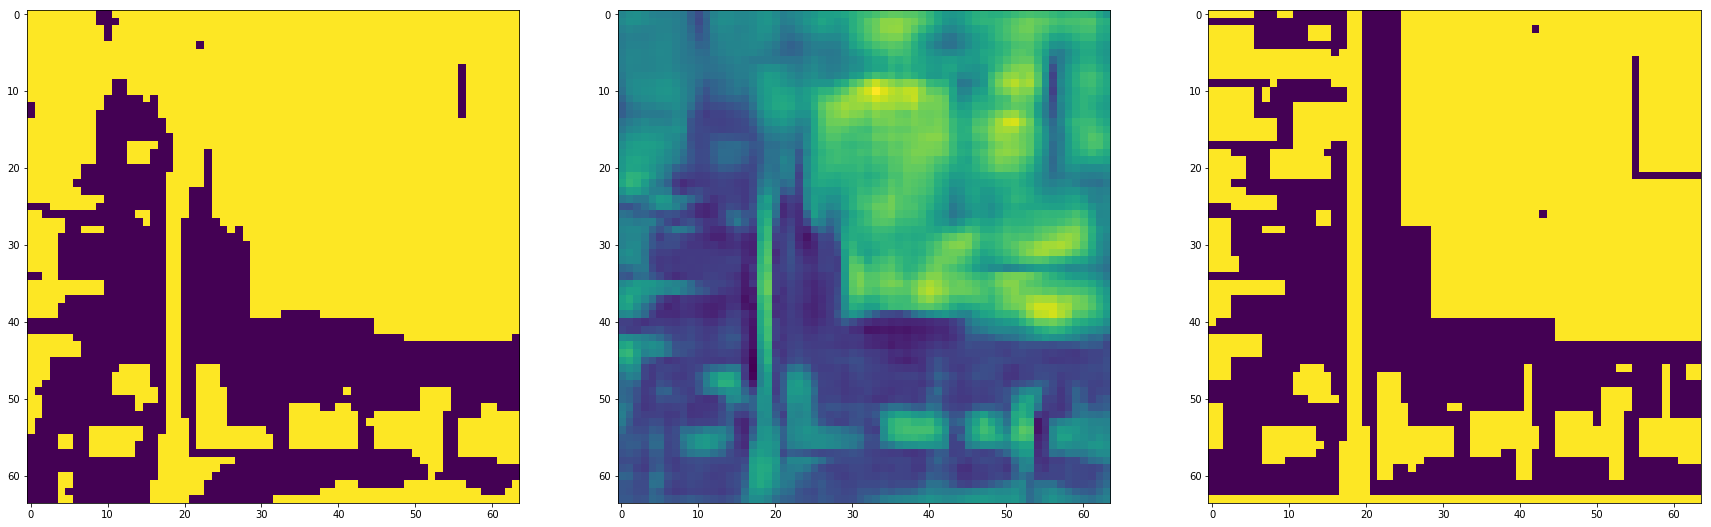

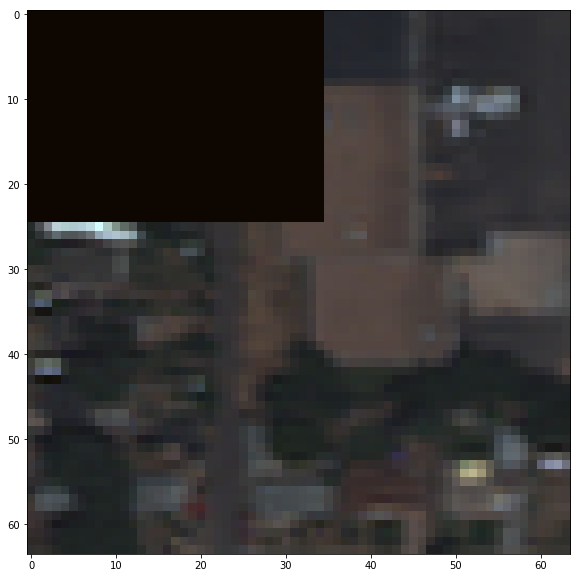

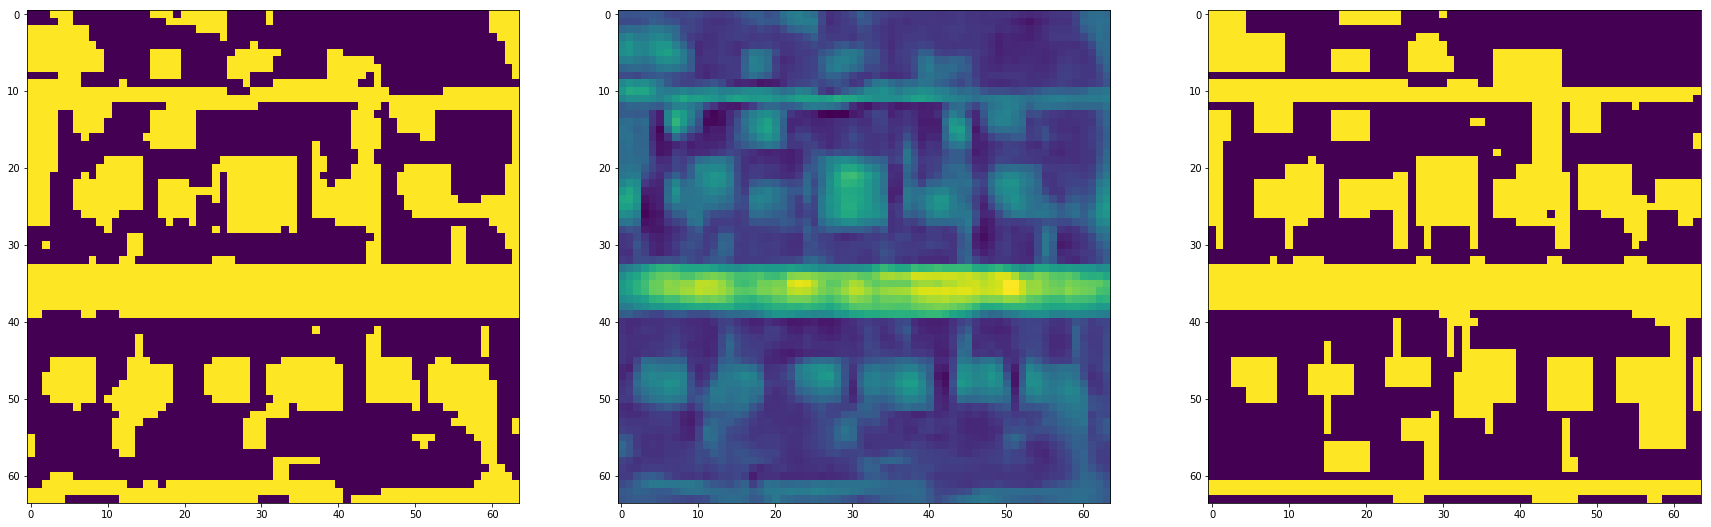

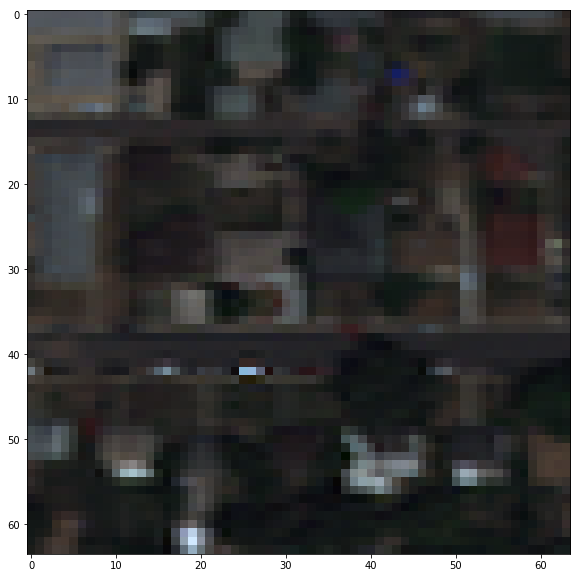

invalid argument 3: Source tensor must be contiguous at /opt/conda/conda-bld/pytorch_1532576276790/work/aten/src/THC/generic/THCTensorCopy.cpp:114


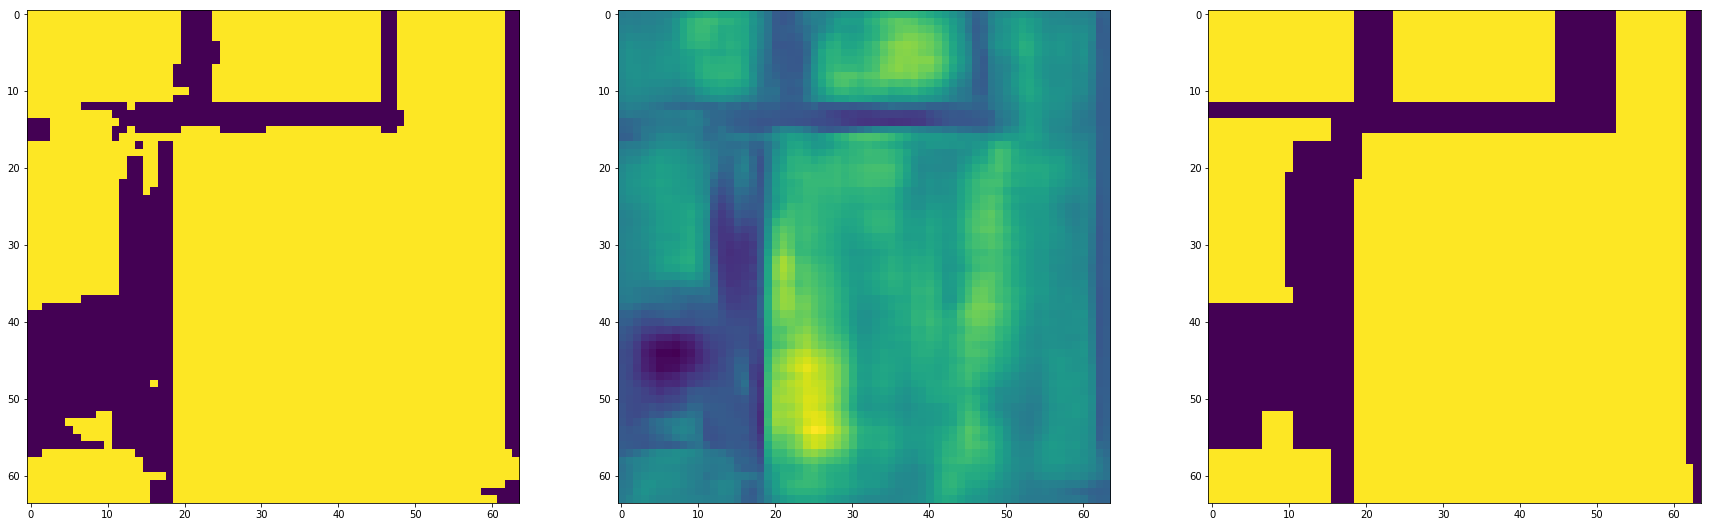

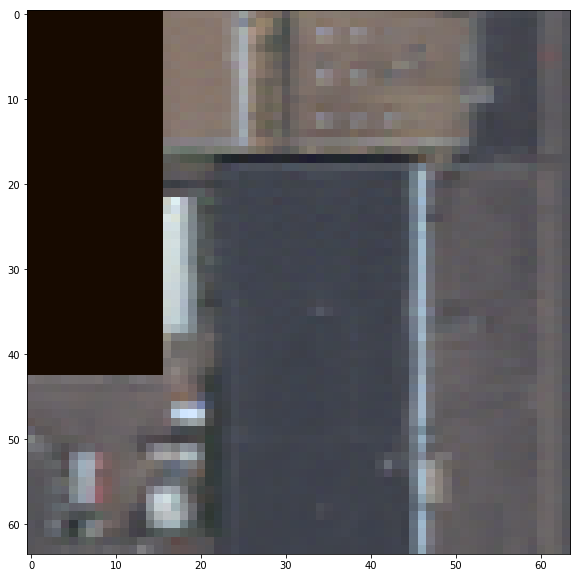

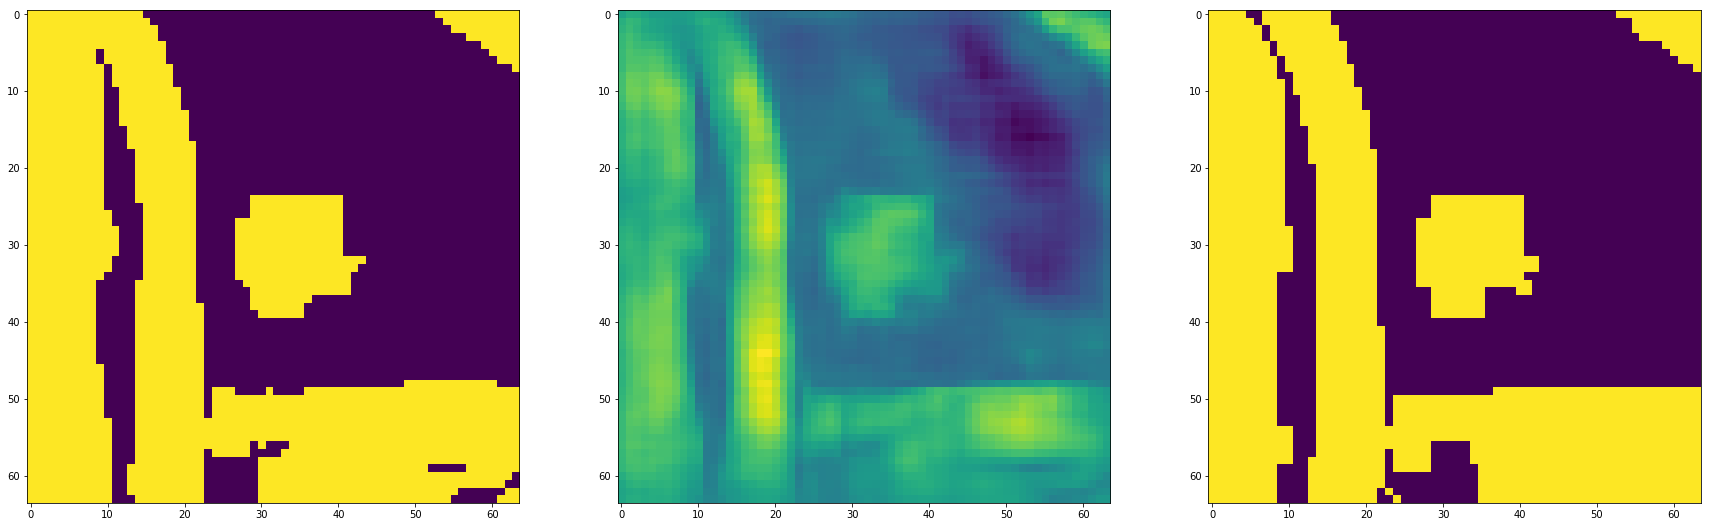

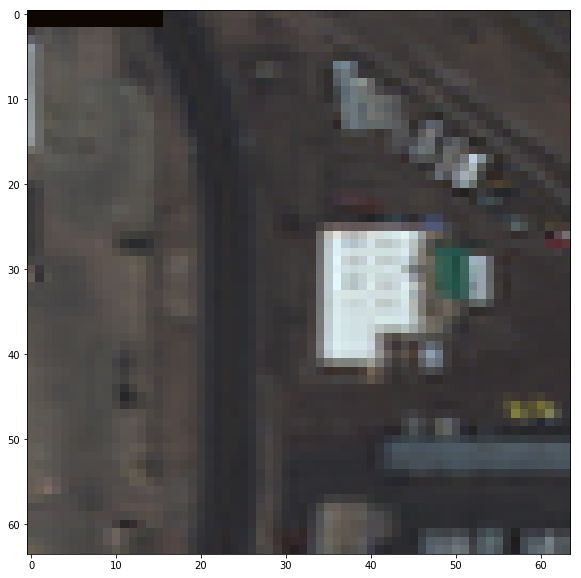

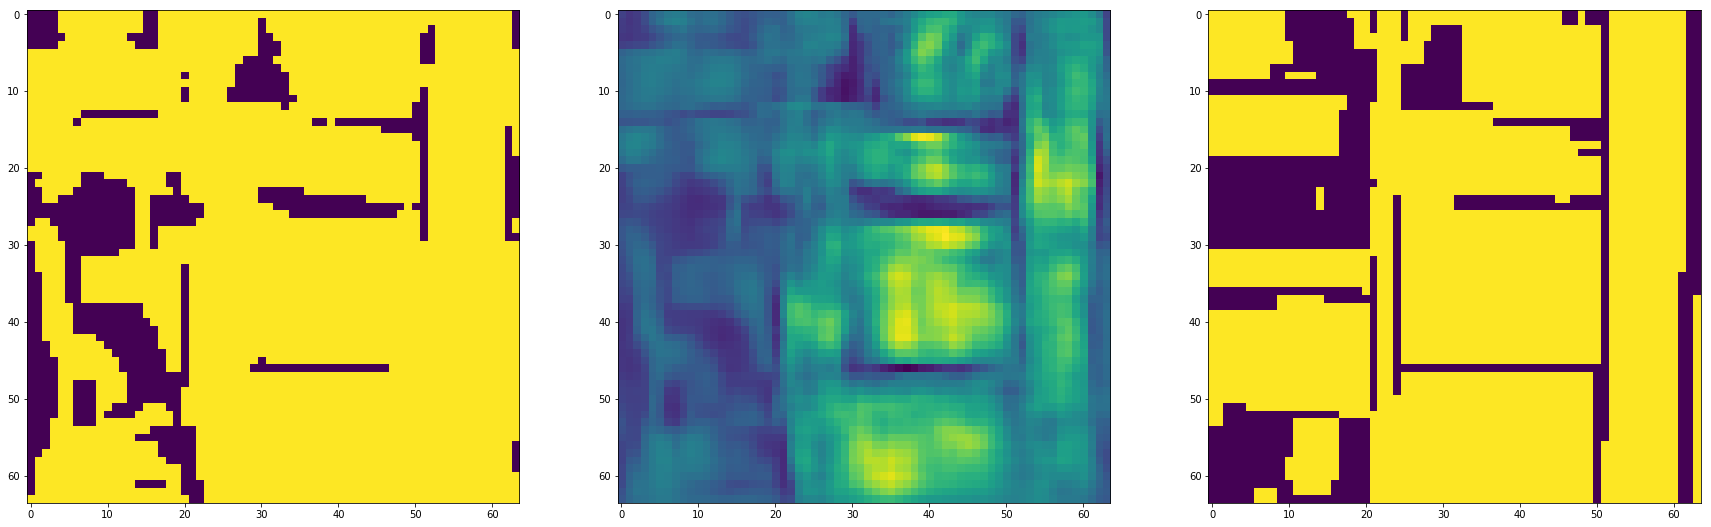

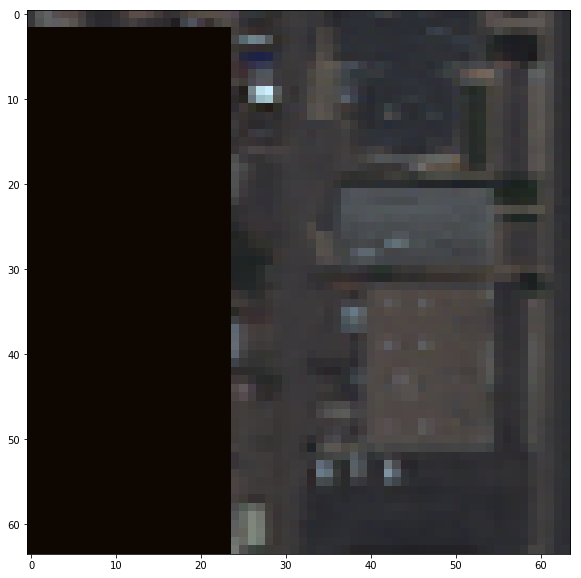

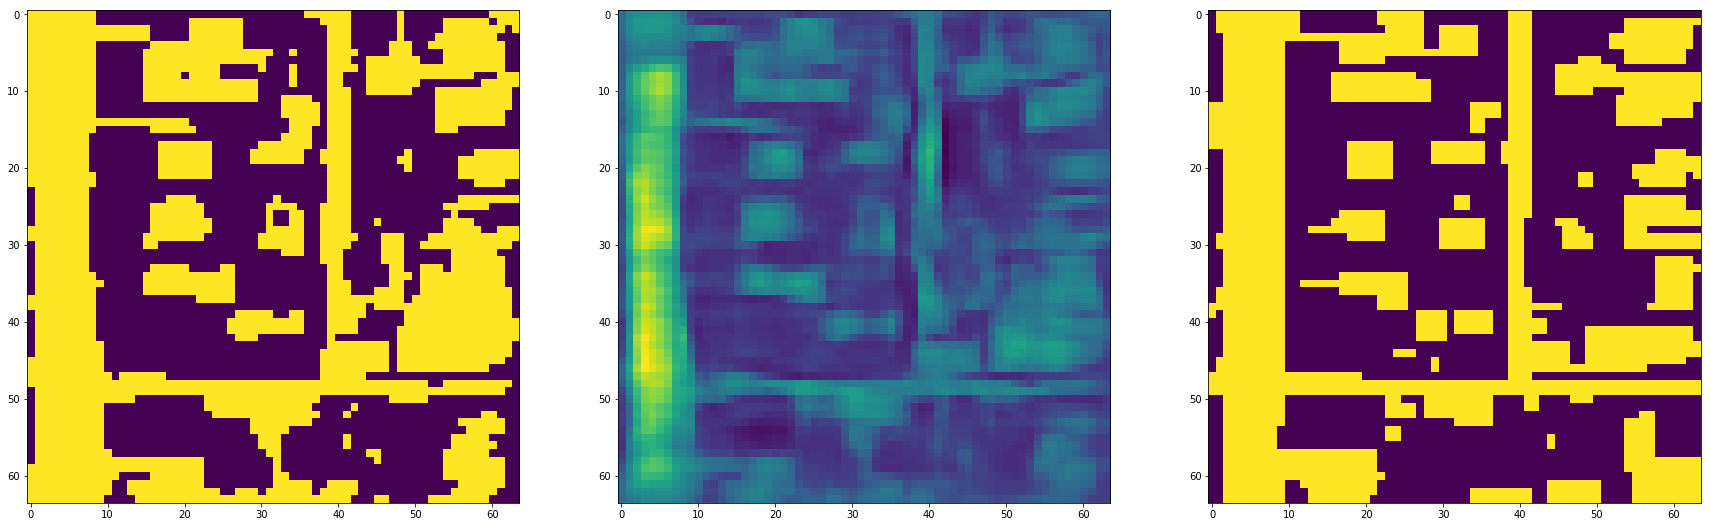

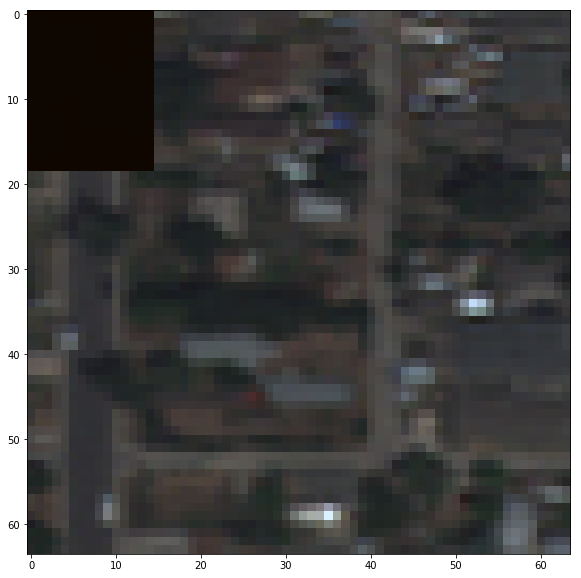

In [28]:
# check one of the test images
test_inds = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]
for test_ind in test_inds:
    
    try:
        input_img = torch.unsqueeze(variable(dg_dataset_test[test_ind], volatile=True), dim=0) 
        mask = model(input_img)


        mask_im = mask.squeeze().data.cpu().numpy()
        mask_binary = mask_im.copy()

        fig, ax = plt.subplots(1,3, figsize=(30,10))
        thresh = 0
        mask_binary[mask_im<=thresh] = 0
        mask_binary[mask_im>thresh] = 1
        ax[0].imshow(mask_binary)
        # ax[0].colorbar()
        ax[1].imshow(mask_im)
        gt_im = gt_dataset_test[test_ind].numpy().squeeze()
        ax[2].imshow(gt_im)
        # ax[1].colorbar()
        plt.show()

        fig = plt.figure(figsize=(10,10))
        source_im = dg_dataset_test[test_ind].numpy()
        plt.imshow(misc.bytescale(np.rollaxis(source_im[[4,2,1],:,:], 0, 3)))
        plt.show()
    
    except Exception as e:
        print(e)
        pass


In [ ]:
# # temp code to keep running overnight
# timeout = time.time() + 60*60*12   # 5 hours from now
# while True:
#     test = 0
#     time.sleep(1)
#     if test == 5 or time.time() > timeout:
#         break
#     test = test - 1

In [ ]:
# # save current state
# save = lambda ep: torch.save({
#         'model': model.state_dict(),
#         'epoch': ep,
#         'step': step,
#     }, str(model_path))

# root = Path('runs/debug')
# model_path = root / 'model_e{}_s{}.pt'.format(epoch, step)
# ep=epoch
# step=i

# save(ep)

In [ ]:
# #load model
# if model_path.exists():
#     state = torch.load(str(model_path))
#     epoch = state['epoch']
#     step = state['step']
#     model.load_state_dict(state['model'])
#     print('Restored model, epoch {}, step {:,}'.format(epoch, step))